In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from galaxy2galaxy import problems
import tensorflow as tf
from scipy.ndimage import convolve
import pickle
from itertools import chain

tf.enable_eager_execution()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
import sys
path = '/local/home/ua264756/GitHub/ADMM/'
sys.path.insert(1, path)

import plot_utils
from helper_func import *

data_path = '/local/home/ua264756/Data/'

In [3]:
tf.executing_eagerly()

True

### Pre-processing Function

In [4]:
norm_fact = 100

def pre_proc_unet(dico):
    r"""Preprocess the data and adds noise to generate the input galaxy images.

    This function takes the dictionnary of galaxy images and PSFs for the input and
    the target and returns a list containing 3 arrays: an array of noisy galaxy images, 
    an array of target galaxy images, and an array of PSFs

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 3 arrays: an array of noisy galaxy images, 
        an array of target galaxy images, and an array of PSFs
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
        
    # Normalize tagets 
    dico['targets'] *= norm_fact 
    
    # Interpolation
    x_interpolant = tf.image.ResizeMethod.BICUBIC
    Nx, Ny = np.shape(dico['targets'])[0], np.shape(dico['targets'])[1]

    # Noisemap
    sigma_noise = 3e-2
    noisemap = tf.random_normal(shape=(Nx, Ny), mean=0.0, stddev=sigma_noise, dtype=tf.float32)
    
    # Add noise to inputs
    dico['inputs']  = tf.squeeze(dico['targets']) + noisemap

    # Resize PSF to 128 X 128 using area interpolation
    # dico['psf'] originally in Fourier Space  ->  converted & overwritten to Direct space
    dico['psf'] = tf.signal.ifftshift(tf.signal.irfft2d(tf.cast(tf.squeeze(dico['psf']), tf.complex64)))
    dico['psf'] = tf.image.resize(tf.expand_dims(dico['psf'], axis=-1), [Nx, Ny], method = x_interpolant) 
    dico['psf'] = tf.squeeze(dico['psf'])
    dico['psf'] /= tf.math.reduce_sum(dico['psf'])
 
    return dico

### Loading Galaxy Images & PSF

In [5]:
with tf.compat.v1.Session() as sess:
    
    # Let's create an instance of the meerkat_3600 problem
    Modes = tf.estimator.ModeKeys
    problem128 = problems.problem('meerkat_3600')
    dset = problem128.dataset(Modes.EVAL, data_dir=data_path+'meerkat_3600')
    dset = dset.repeat()
    dset = dset.map(pre_proc_unet)
    n_batch = 2000
    dset = dset.batch(n_batch)

    # Build an iterator over the dataset
    iterator = dset.make_one_shot_iterator().get_next()

    # Initialize batch
    batch = sess.run(iterator)


INFO:tensorflow:Reading data files from /local/home/ua264756/Data/meerkat_3600/meerkat_3600-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [6]:
for i in range(2000):
    
    # Convolution with PSF
    batch['inputs'][i] = convolve(batch['inputs'][i], batch['psf'][i], mode='constant', cval=0.0)

In [7]:
# Save Batch
f = open(data_path + "meerkat_batch_2000.pkl", "wb")
pickle.dump(batch, f)
f.close()

### Load Trained U-Net Model

In [8]:
model_1 = tf.keras.models.load_model(path + 'UNet_Denoiser/Models/UNet_radio_F{3600}_ep{20}spe{6250}nb{32}_WGN_fact{100}_SNR{1-50}', compile=False)

# Forward-Backward Algorithm

#### The loss function

$ L(x) = \frac{1}{2\sigma^2} \lVert Hx - y \rVert_2^2 \\\\\\ 
\nabla L(x) = \frac{1}{\sigma^2} H^T(Hx - y)  \\\\\\
\nabla L(x_{true}) = \frac{1}{\sigma^2} H^Tn; \hspace{0.75cm} since \hspace{0.5cm} y = Hx_{true} + n\hspace{0.75cm} s.t. \hspace{0.5cm} n \hspace{0.25cm} WAGN \\\\\\ $

#### Compute Variance of -

$ \hspace{0.75cm} \alpha\nabla L(x_{true}) = \frac{\alpha}{\sigma^2} H^Tn \\\\\\ 
\hspace{0.75cm} \text {Cov[} \alpha \nabla L(x_{true})] = \frac{\alpha^2}{\sigma^4} \text {Cov[}(H^Tn)] = \frac{\alpha^2}{\sigma^4} \sigma^2 H^T H;  \hspace{0.75cm} \text{as  Cov(} H^Tn) = H^T \text{Cov(} n) (H^T)^T \\\\\\
\Rightarrow \hspace{0.25cm} {Cov[} \alpha \nabla L(x_{true})] = \frac{\alpha^2}{\sigma^2} H^TH \\\\\\ $

#### Now, 

$\hspace{0.8cm} AA^T [i,i] = \sum_j A[i,j]A^T[j,i] = \sum_j A^2[i,j] = \lVert A \rVert_F^2 \\\\\\ 
\therefore \hspace{0.25cm} \text {Cov(} \alpha \nabla L(x_{true}))[i,i] = \frac{\alpha^2}{\sigma^2} \lVert H \rVert_F^2 \\\\\\ 
\Rightarrow \hspace{0.25cm} \sigma_{grad} = \alpha \lVert H \rVert_F \sigma_{U-Net}\\\\\\ $


#### After plugging U-Net

$ L(x) = L_d + p(x), \hspace{0.75cm} where \hspace{0.5cm} L_d(x) = \frac{1}{2\sigma^2} \lVert Hx - y \rVert_2^2\\\\\\ $

##### Forward backward Splitting
While not converged:
$ \hspace{0.5cm} X^{(k+\frac{1}{2})} \leftarrow X^{(k)} - \alpha \nabla L_d(X^{(k)}) $
$\\\\\\ \hspace{4.1cm} X^{(k+1)} \leftarrow prox_\alpha X^{(k+\frac{1}{2})} \\\\\\ $

Note that: 
$ \hspace{0.5cm} Var (\frac{\sigma_0}{\sigma}n) = \frac{\sigma_0^2}{\sigma^2} Var(n) = \sigma_0^2$

##### Empirically estimate standard deviation of $\alpha \nabla L_d(x_{true})$ : $\hspace{0.5cm} \alpha H^T  n$
$ \hspace{0.5cm}x^{(0)} = 0 $
$ \\\\\\ \hspace{0.5cm}x^{(\frac{1}{2})} = x^{(0)} - \alpha \nabla L_d(x_{true}) $
$ \hspace{0.5cm}x^{(\frac{1}{2})} = \alpha H^T n $
$ \\\\\\ \hspace{0.5cm}Hx_{true} - y = n $

##### Check if:

$ \\\\\\ \hspace{0.5cm}np.std(x^{(\frac{1}{2})}) = np.std(\alpha H^T n) \hspace{1.0cm} (Empirical \hspace{0.175cm} value) \\\\\\ \hspace{2.75cm} = \alpha \lVert H \rVert_F \sigma \hspace{2.05cm} (Theoretical \hspace{0.175cm} value) $


In [9]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)
 
    
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, psf, var):

    L_d = (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2      
    return tf.keras.backend.eval(L_d)


# Spectral value
def max_sv(psf):
    
    H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H)
    return tf.cast(tf.math.reduce_max(normH), tf.float32)
     
    
# Compute gradient step size   
def get_alpha(sv):

    return (tf.cast(1.0, tf.float32) / (sv * tf.cast(1.0 + 1.0e-5, tf.float32)))


def runFBS(y, x_0, psf, grad, sigma_noise, n_iter, model):    

    # Convert arrays to tensors 
    x_0 = tf.cast(x_0, tf.float32)
    x_k = x_0     
    sigma = tf.cast(sigma_noise, tf.float32)

    # declare variables    
    cost = np.full(n_iter, np.inf)
    nmse_arr = np.full(n_iter, np.inf)
    
    sv = max_sv(psf)
    alpha = get_alpha(sv)

    for k in range(n_iter):
        
        ## Gradient Descent update  
        x_k1 = x_k - alpha * grad(y, x_k, psf)   
        
        # U-Net Denoising
        x_k1 = tf.expand_dims(tf.expand_dims(x_k1, axis=0), axis=-1)
        x_k1 = tf.cast(tf.squeeze(model(x_k1)), tf.float32)
        
        ## Cost
        cost[k] = cost_func(y, x_k1, psf, var=sigma**2)  
    
        # Update variables
        x_k = x_k1
                
        # Compute NMSE
        nmse_arr[k] = nmse(gal_target, x_k)  
        
        # Stopping Criteria
        if (np.abs(nmse_arr[k]-nmse_arr[k-1]) < 1e-5) or (np.abs(cost[k]-cost[k-1]) < 1e-5):
            return x_k, cost, nmse_arr
                 
    return x_k, cost, nmse_arr

### Run FBS



 Galaxy Index = 1600



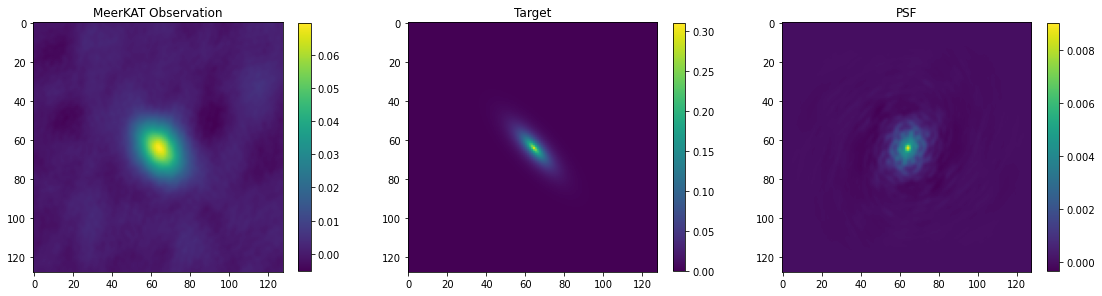

SNR (in Direct Space) = 42.34214660919456
Noise Std (in Direct Space) = 0.0016424262577900662
PSF Flux =  0.9999999



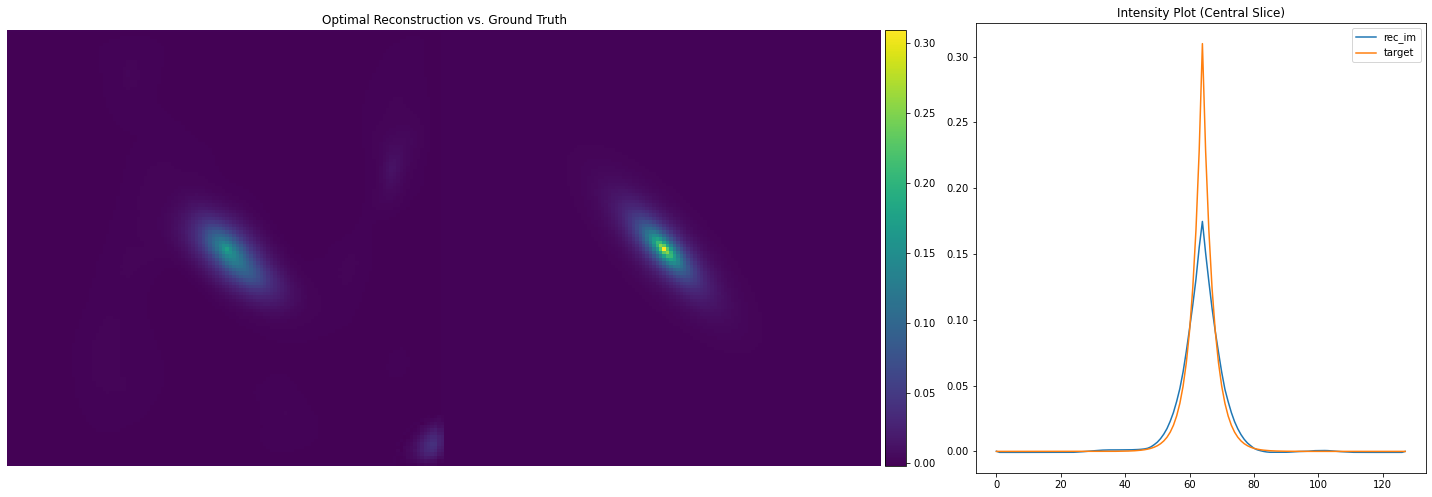

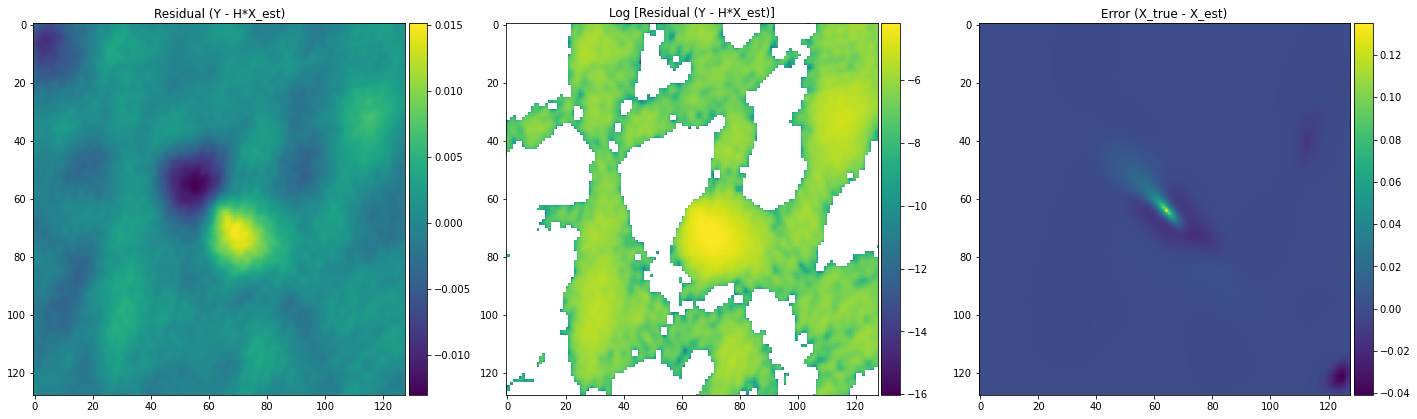

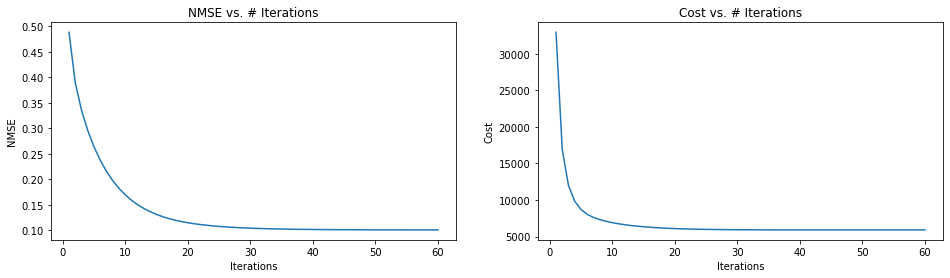


Minimum NMSE = 0.10105939954519272 (at [60] iterations)
Minimum Cost = 5903.3486328125 (at [44] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1590



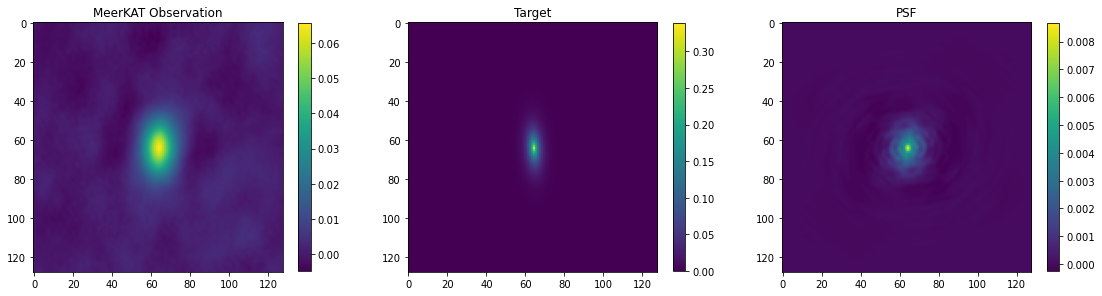

SNR (in Direct Space) = 34.862975821434276
Noise Std (in Direct Space) = 0.0018837610288057476
PSF Flux =  1.0000002



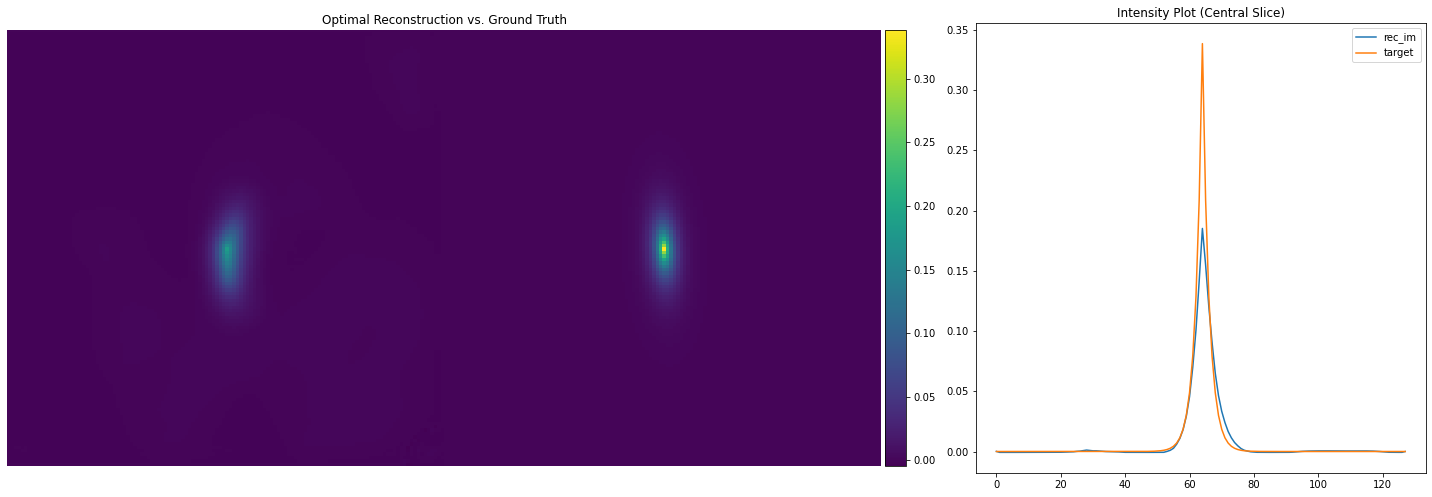

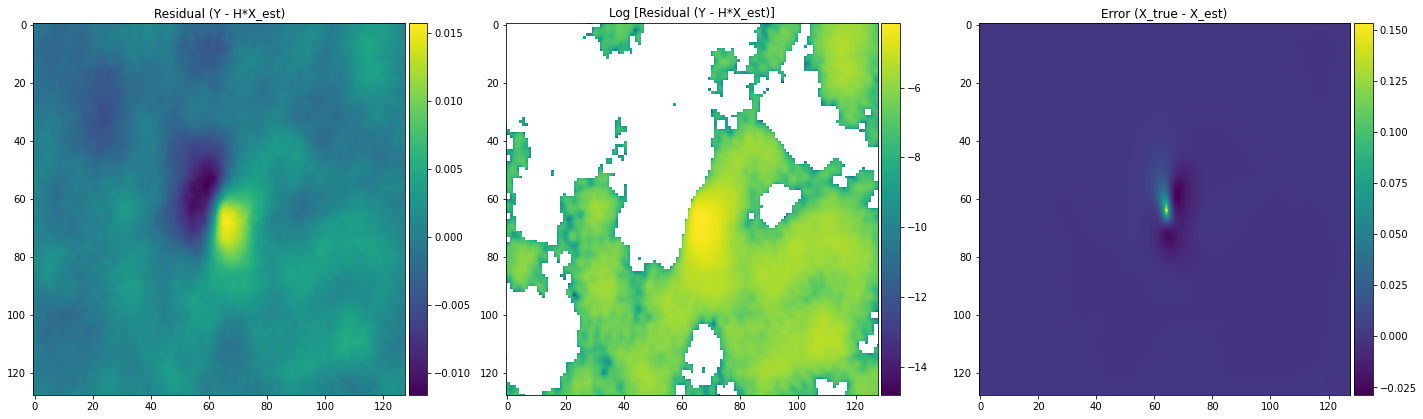

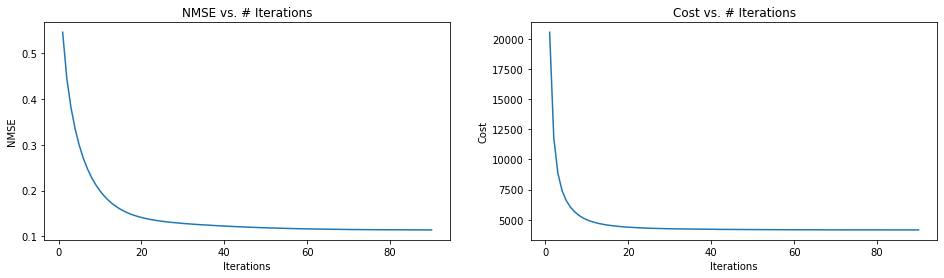


Minimum NMSE = 0.11381296813488007 (at [90] iterations)
Minimum Cost = 4163.0361328125 (at [89] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1580



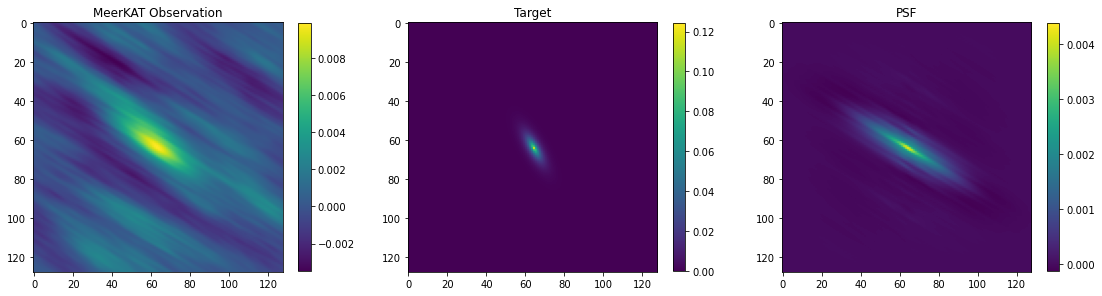

SNR (in Direct Space) = 7.04412067454325
Noise Std (in Direct Space) = 0.001400125631969422
PSF Flux =  0.9999999



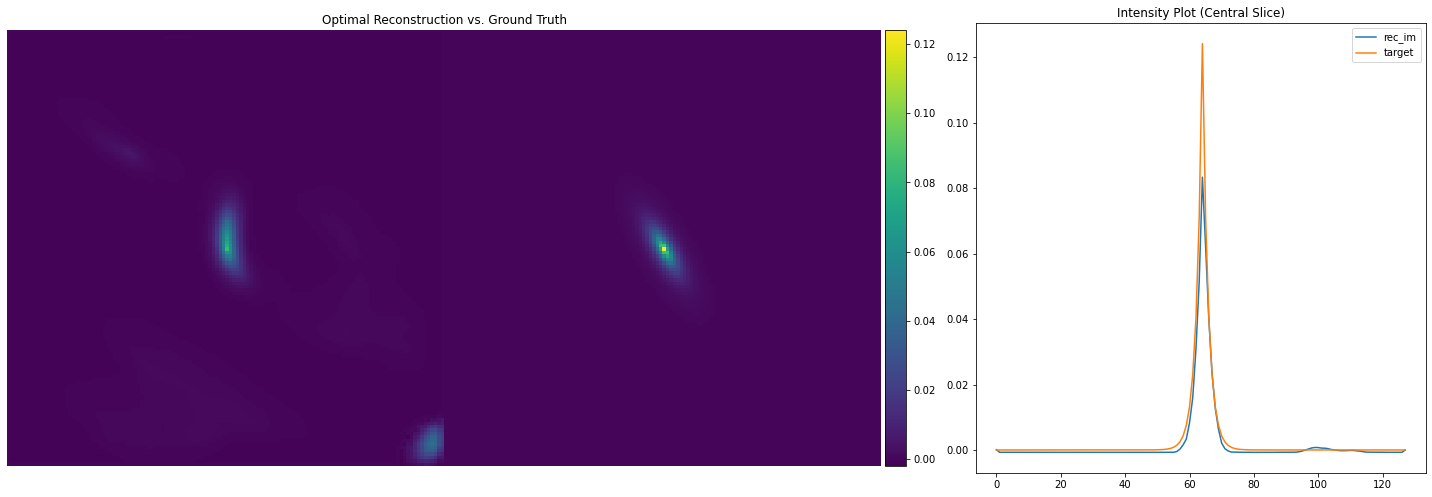

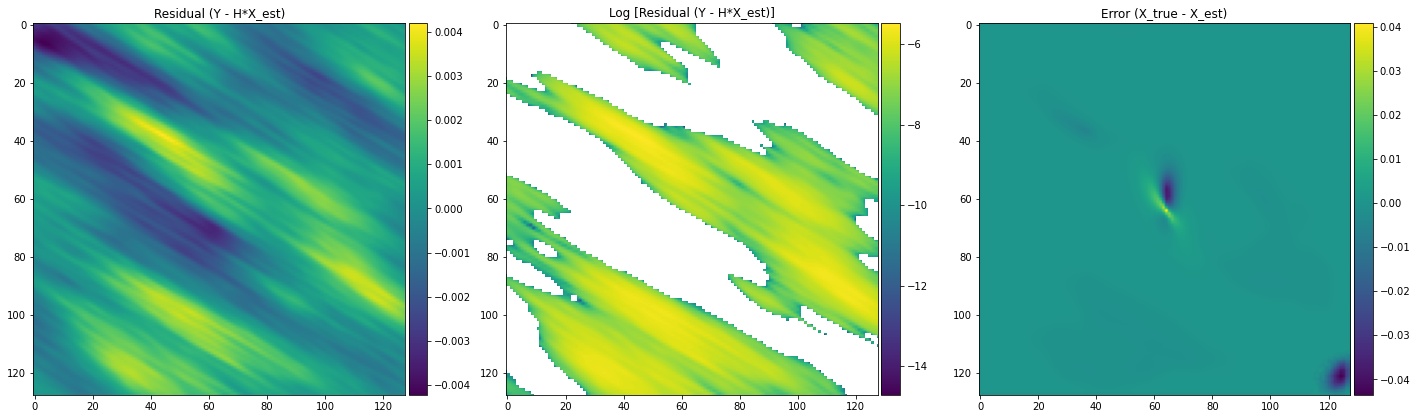

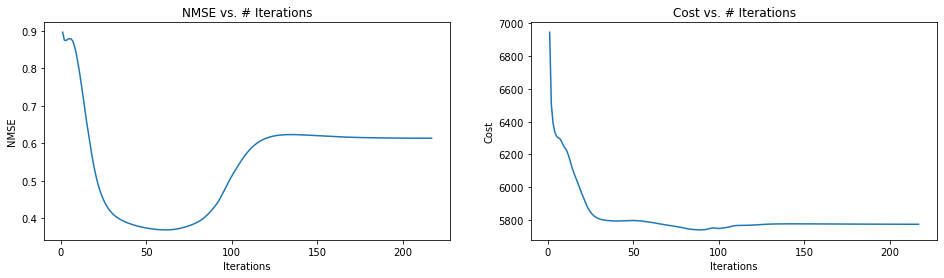


Minimum NMSE = 0.3686794638633728 (at [61] iterations)
Minimum Cost = 5740.01611328125 (at [89] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1570



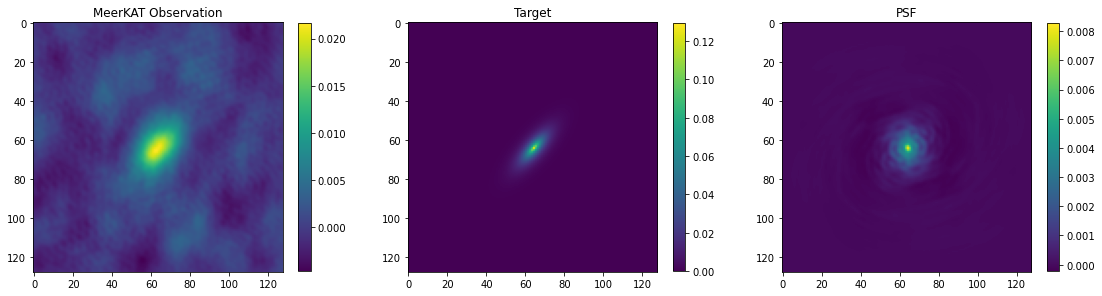

SNR (in Direct Space) = 12.730185204453113
Noise Std (in Direct Space) = 0.0016999895472312346
PSF Flux =  1.0000002



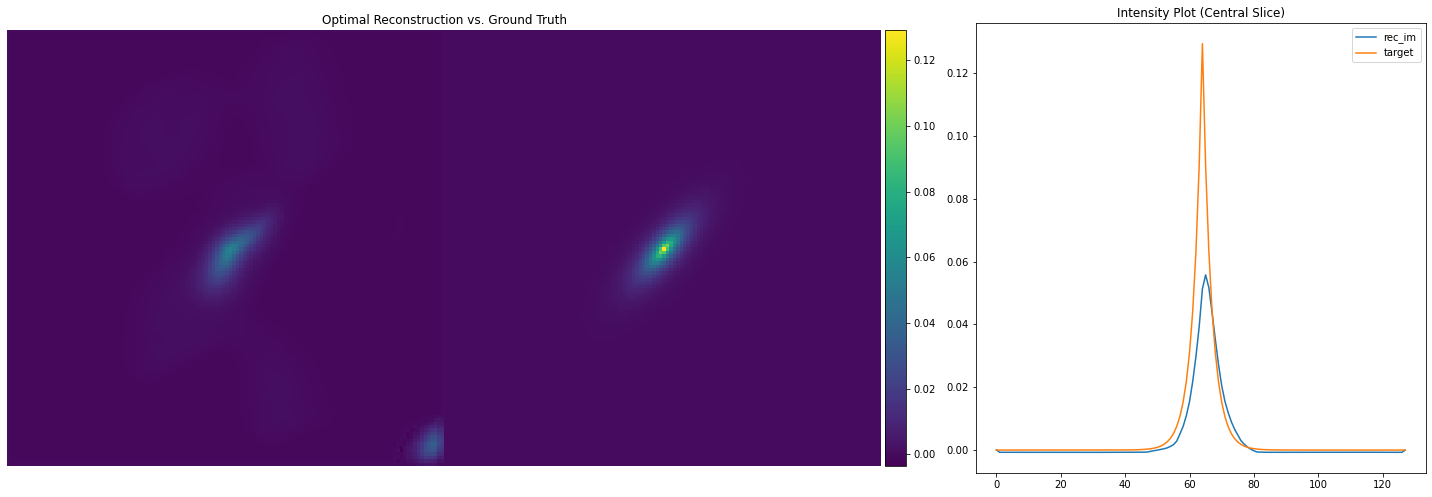

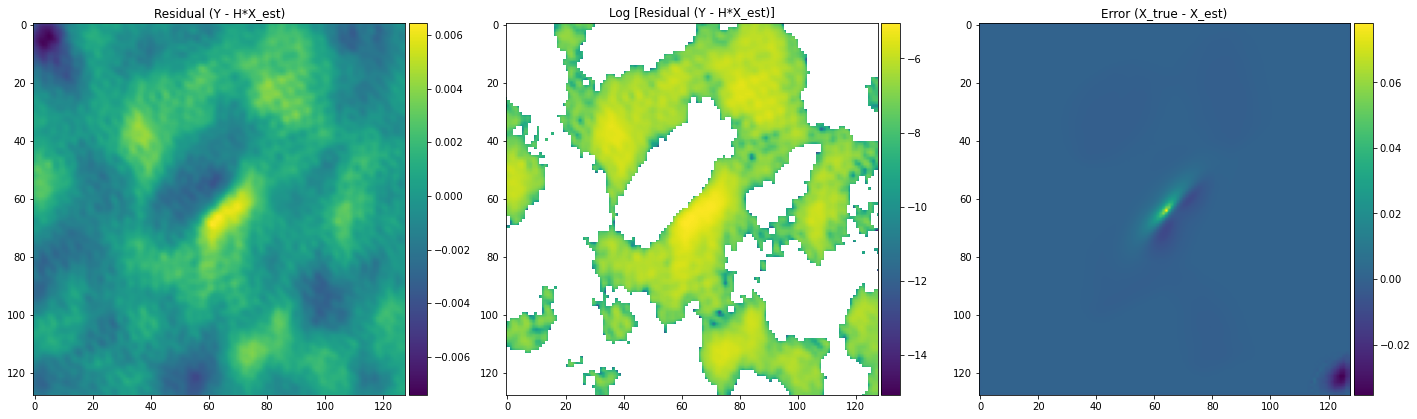

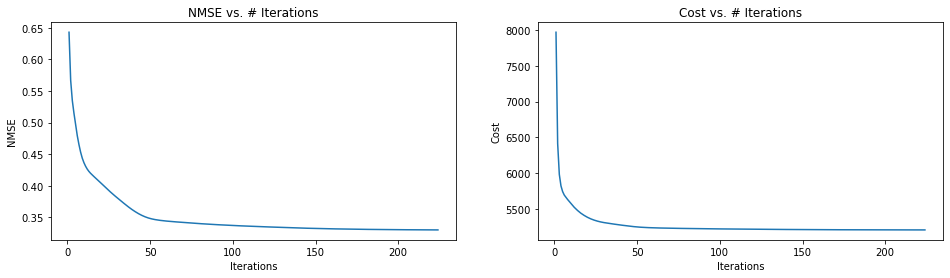


Minimum NMSE = 0.3302795886993408 (at [224] iterations)
Minimum Cost = 5202.46533203125 (at [224] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1560



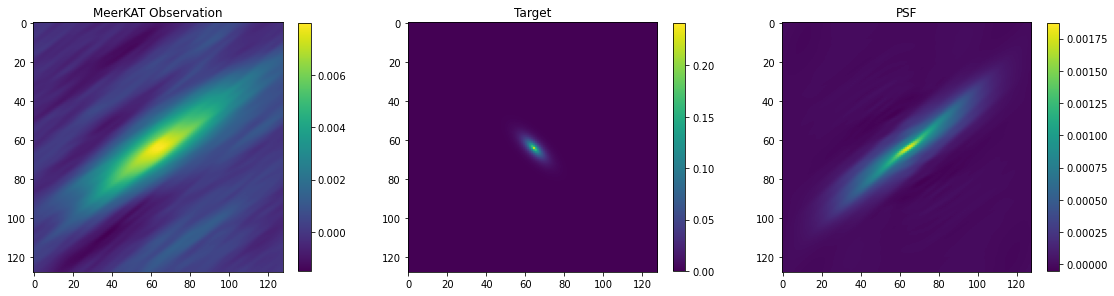

SNR (in Direct Space) = 9.504875259783834
Noise Std (in Direct Space) = 0.0008409928722074255
PSF Flux =  1.0000001



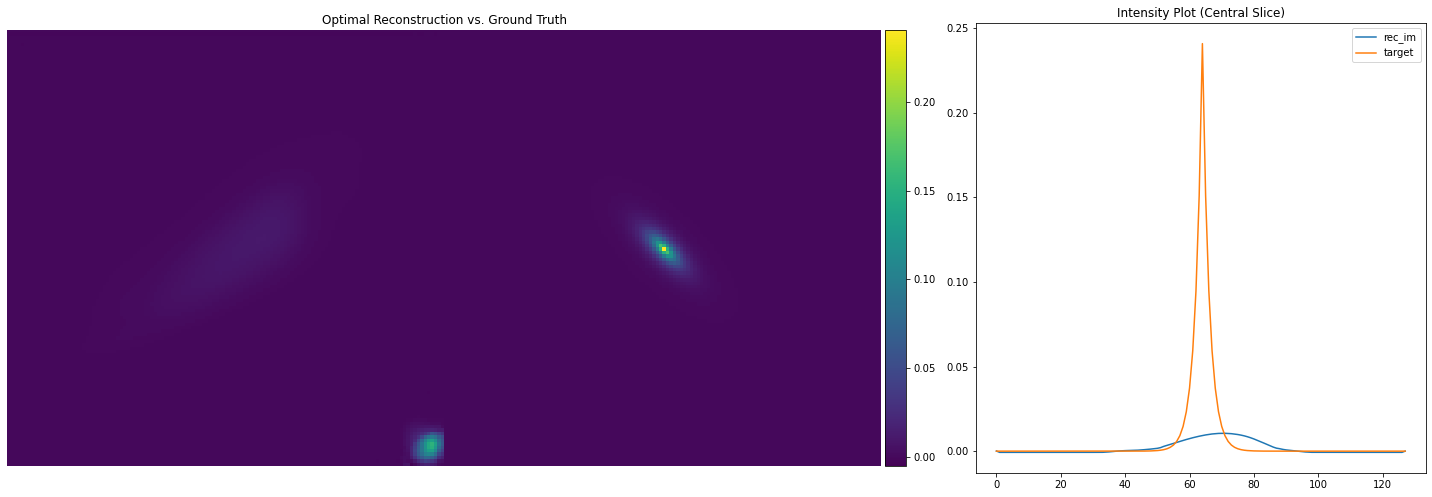

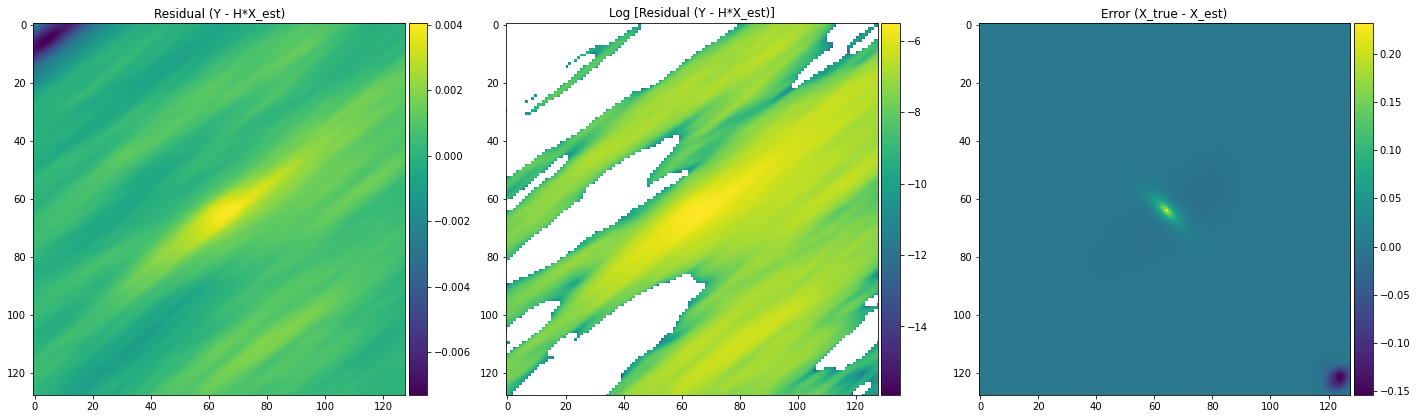

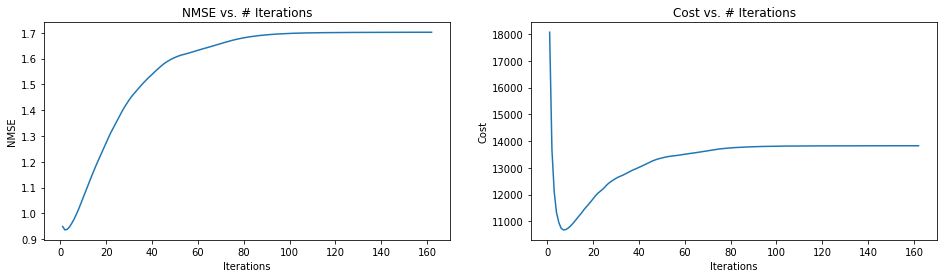


Minimum NMSE = 0.9359802603721619 (at [2] iterations)
Minimum Cost = 10677.3828125 (at [7] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1550



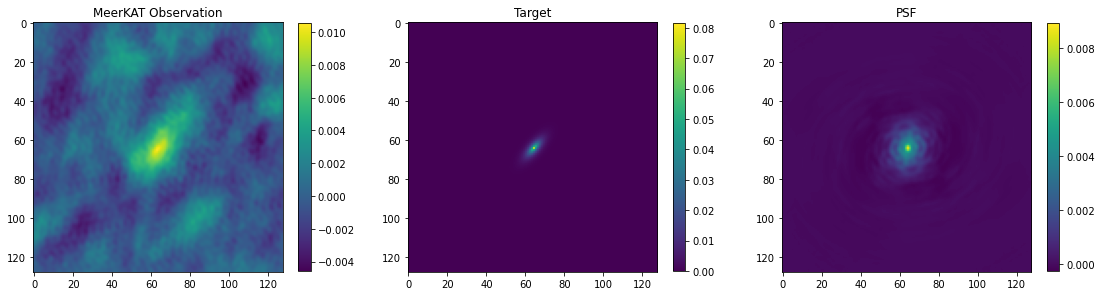

SNR (in Direct Space) = 6.977992074271551
Noise Std (in Direct Space) = 0.0015112374237505719
PSF Flux =  1.0000005



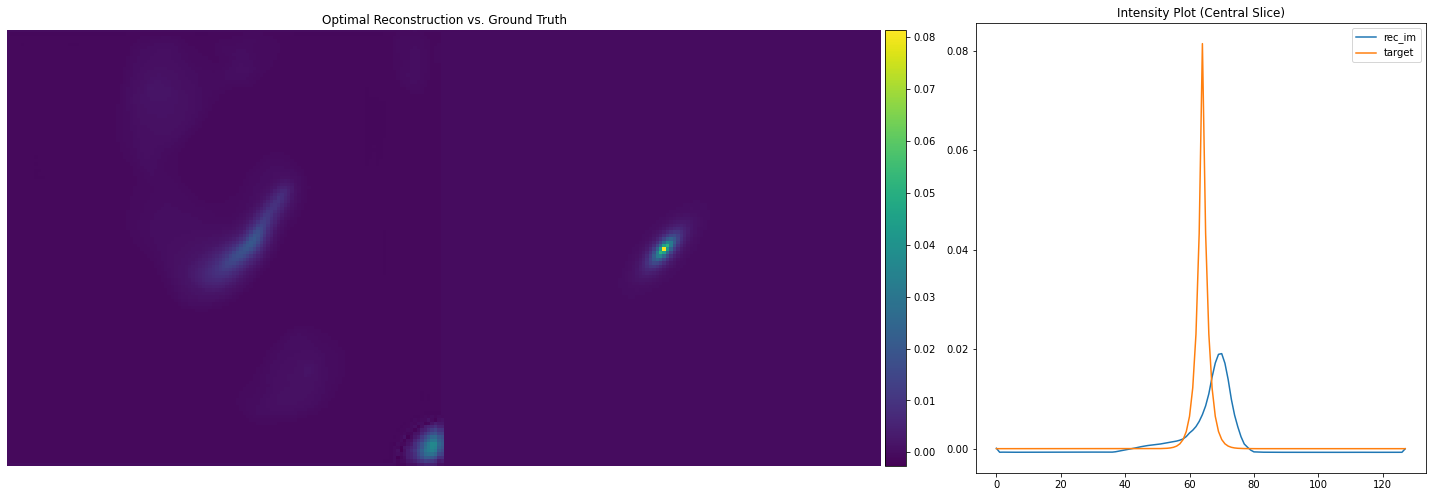

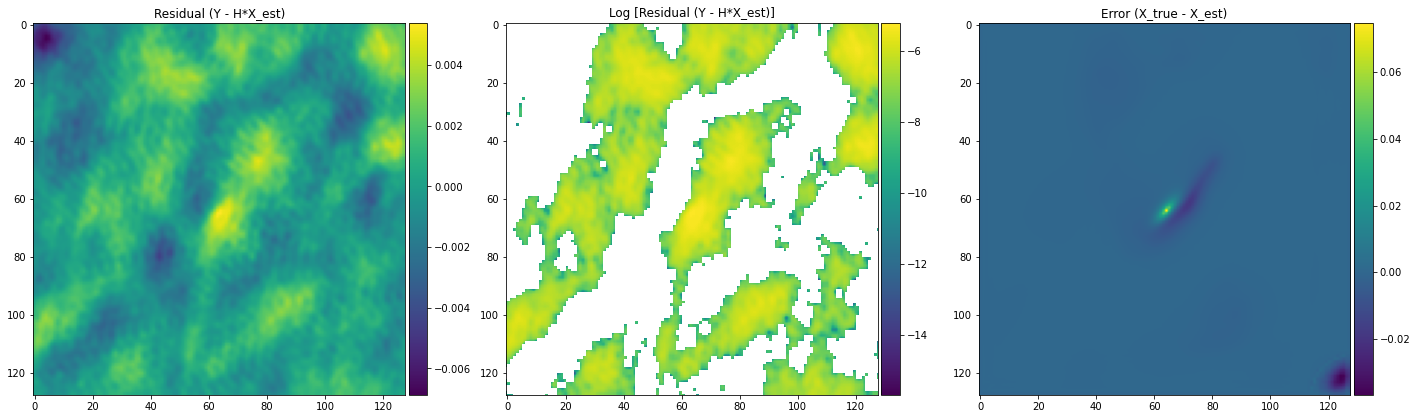

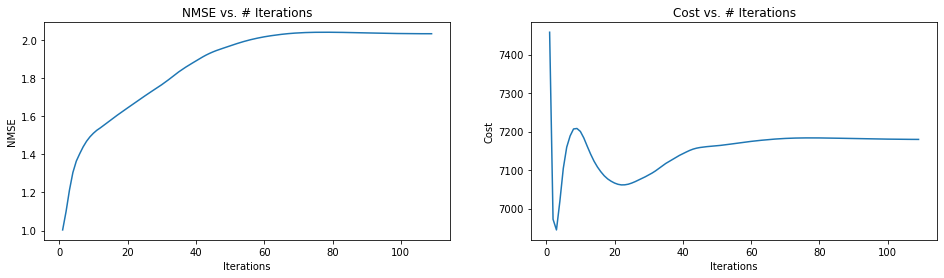


Minimum NMSE = 1.0030945539474487 (at [1] iterations)
Minimum Cost = 6944.634765625 (at [3] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1540



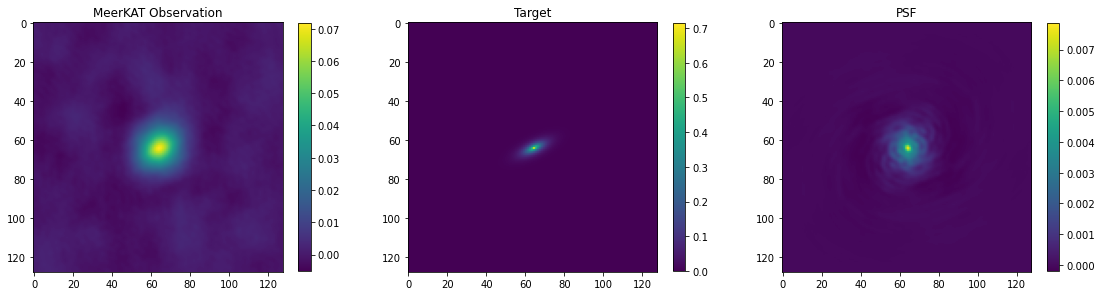

SNR (in Direct Space) = 43.46343641648287
Noise Std (in Direct Space) = 0.00164997238679789
PSF Flux =  0.99999994



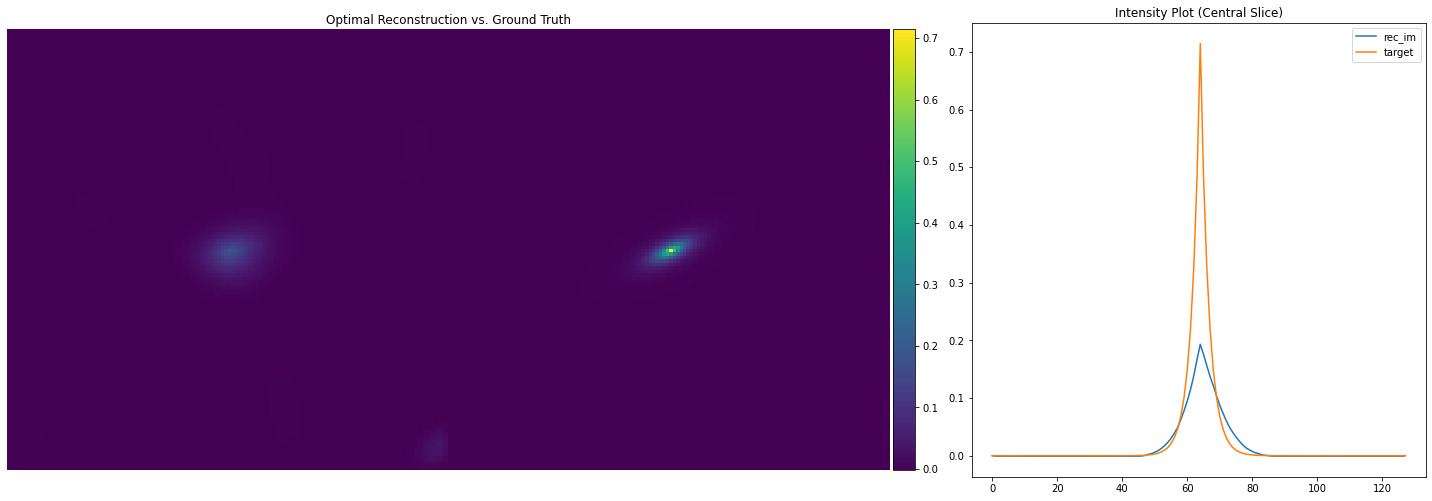

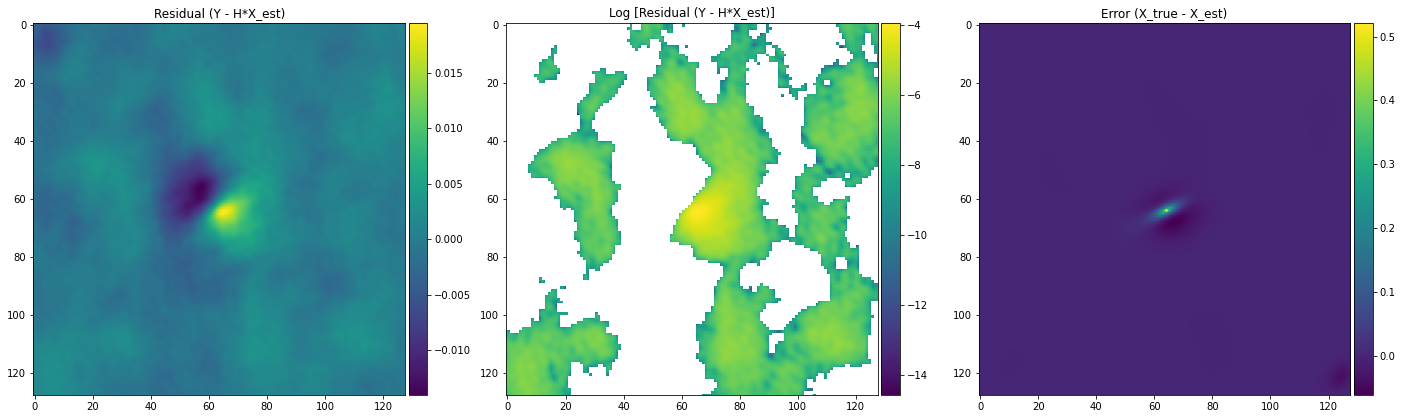

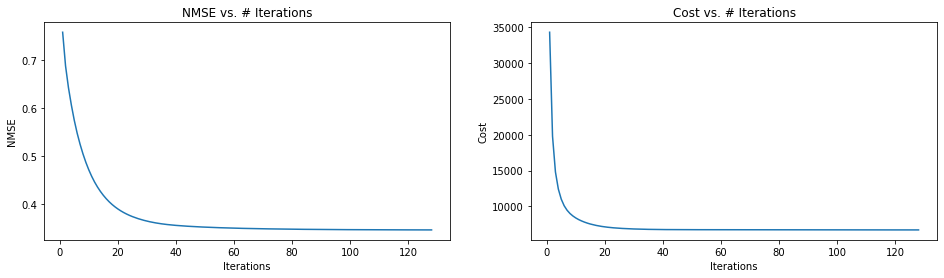


Minimum NMSE = 0.34666845202445984 (at [128] iterations)
Minimum Cost = 6733.75146484375 (at [128] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1530



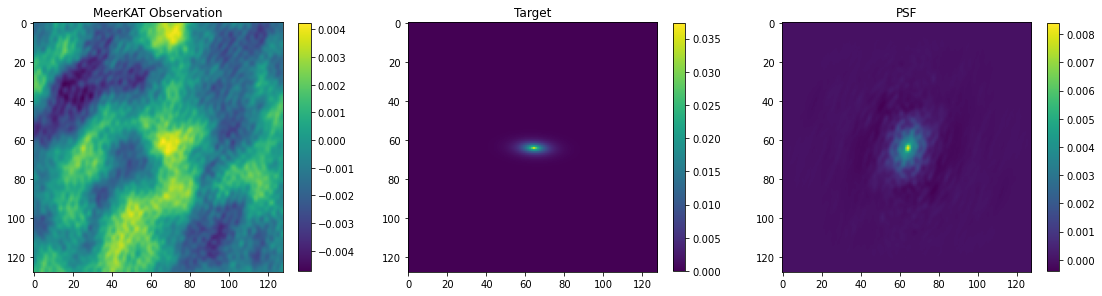

SNR (in Direct Space) = 2.348022111468689
Noise Std (in Direct Space) = 0.001798486543446779
PSF Flux =  1.0



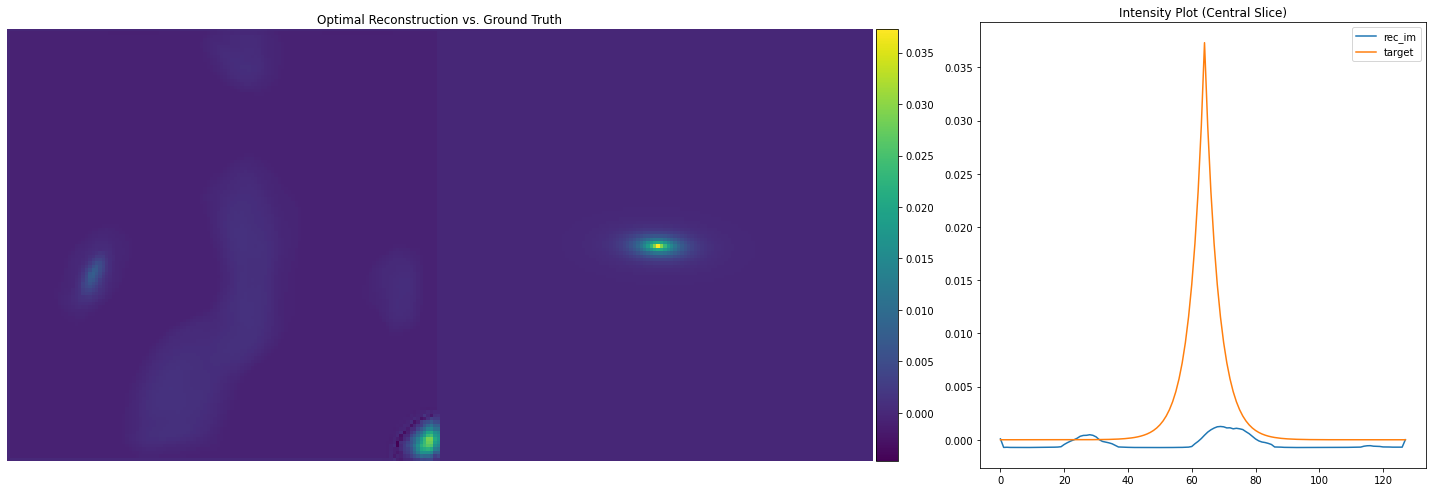

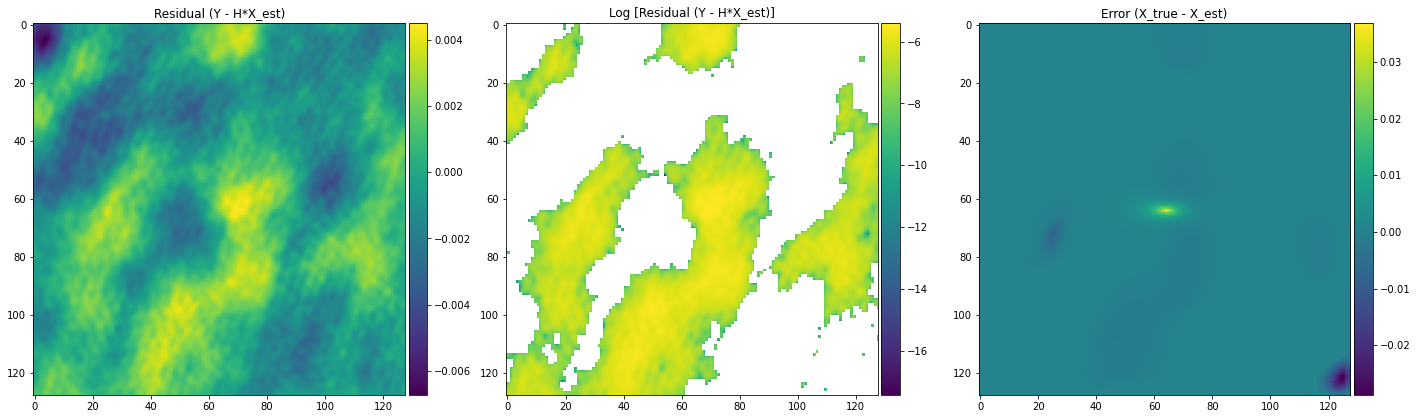

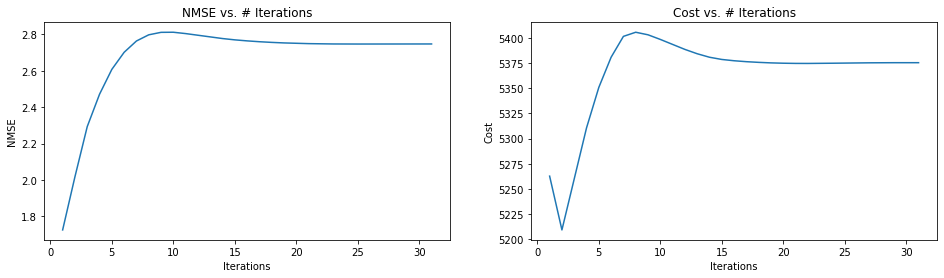


Minimum NMSE = 1.725926160812378 (at [1] iterations)
Minimum Cost = 5209.34619140625 (at [2] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1520



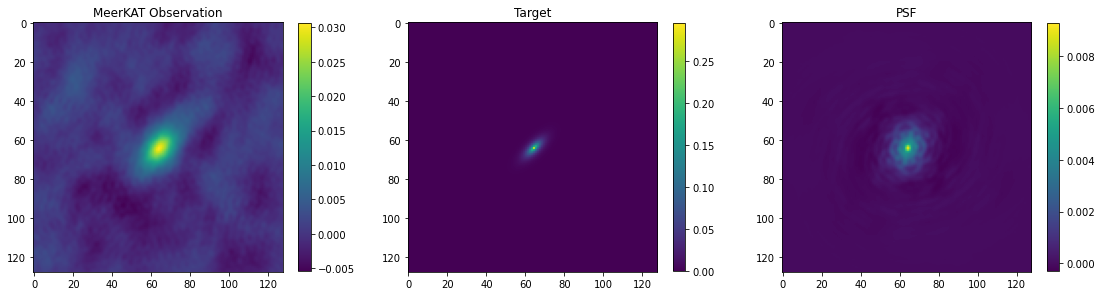

SNR (in Direct Space) = 17.357208363925498
Noise Std (in Direct Space) = 0.0017633358836872503
PSF Flux =  1.0000004



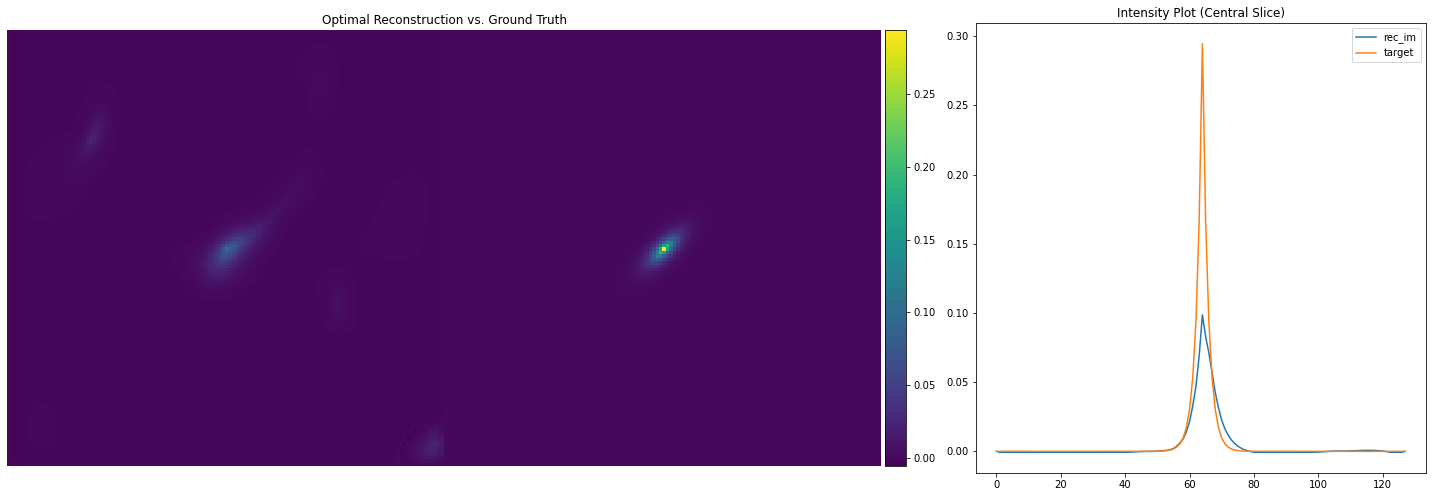

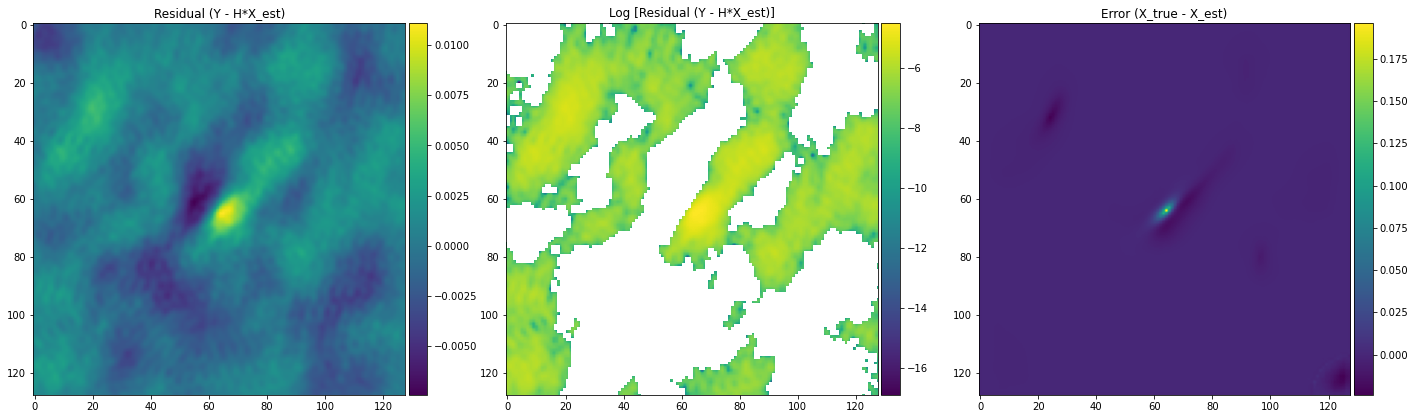

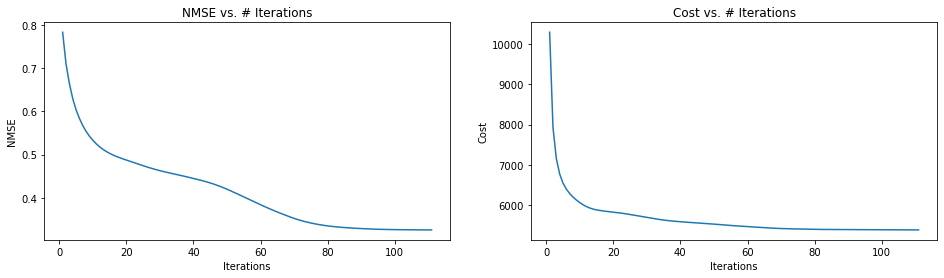


Minimum NMSE = 0.32542744278907776 (at [110] iterations)
Minimum Cost = 5389.0380859375 (at [110] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1510



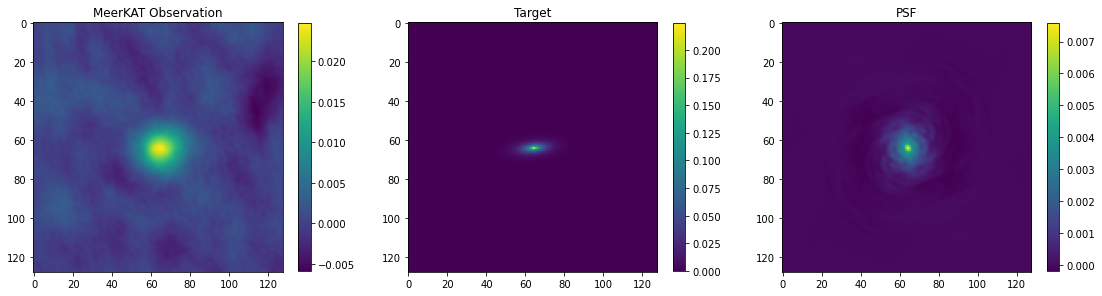

SNR (in Direct Space) = 18.821732679901896
Noise Std (in Direct Space) = 0.0013129996084724552
PSF Flux =  0.9999999



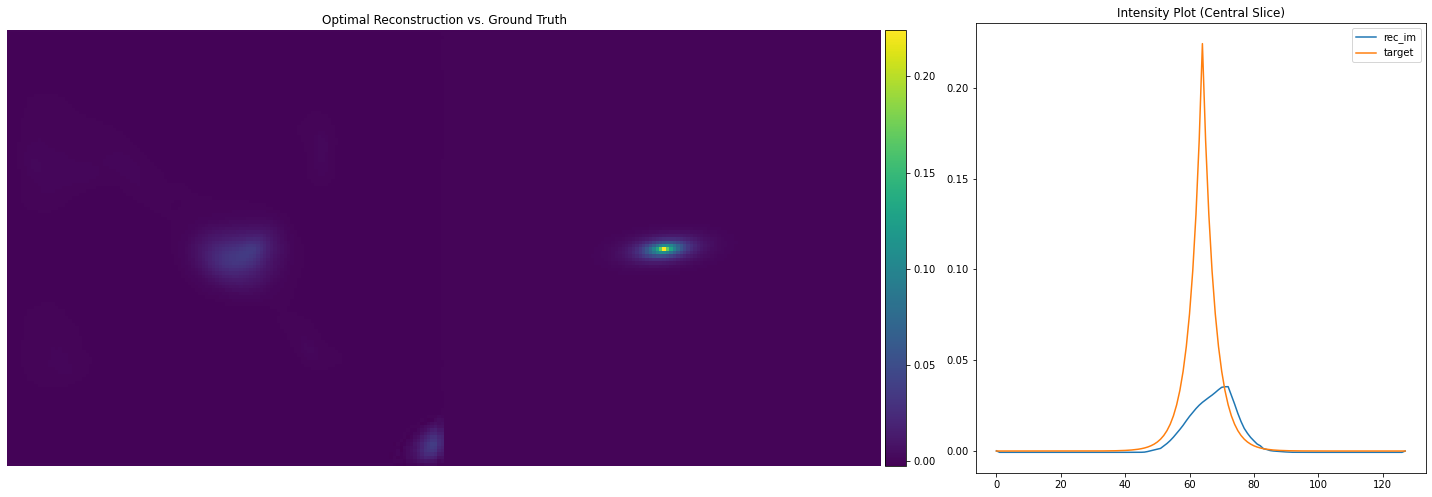

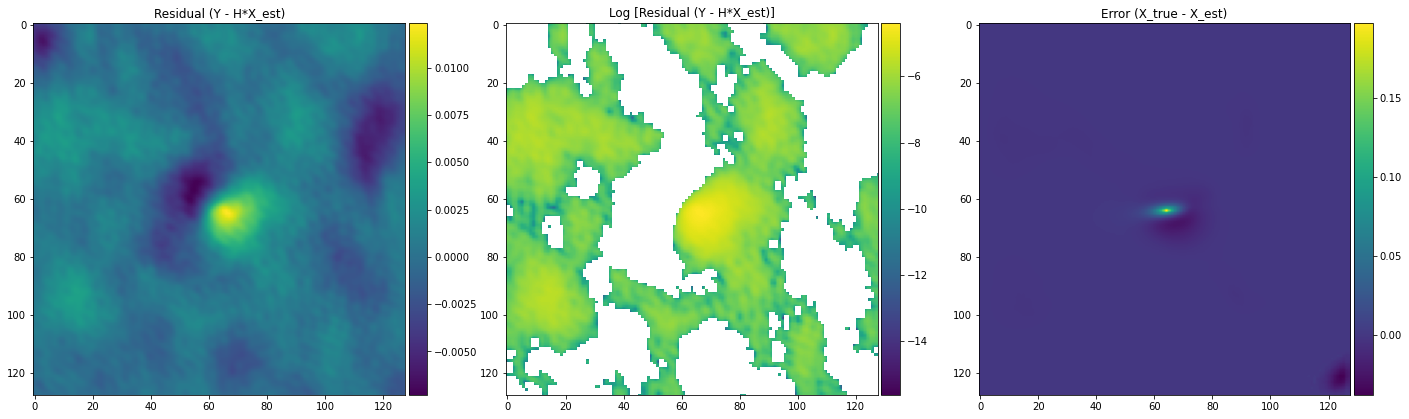

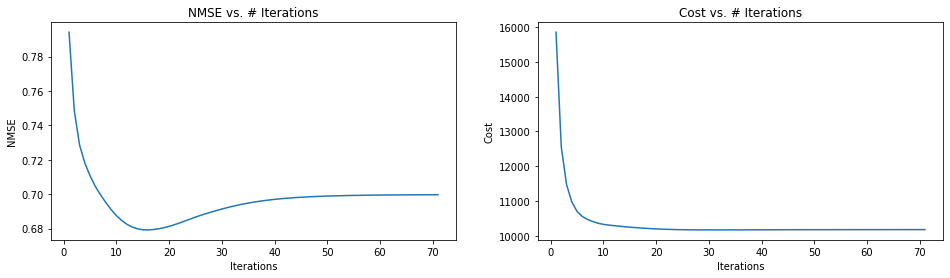


Minimum NMSE = 0.6792376041412354 (at [16] iterations)
Minimum Cost = 10168.1240234375 (at [32] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1500



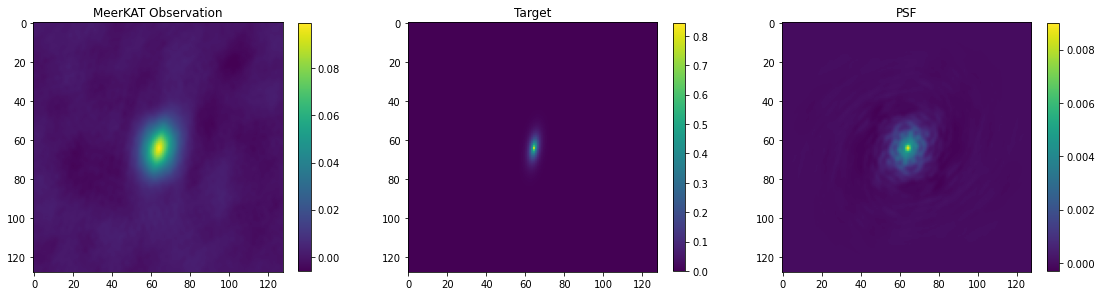

SNR (in Direct Space) = 52.8675477407672
Noise Std (in Direct Space) = 0.0018754908538889138
PSF Flux =  0.9999999



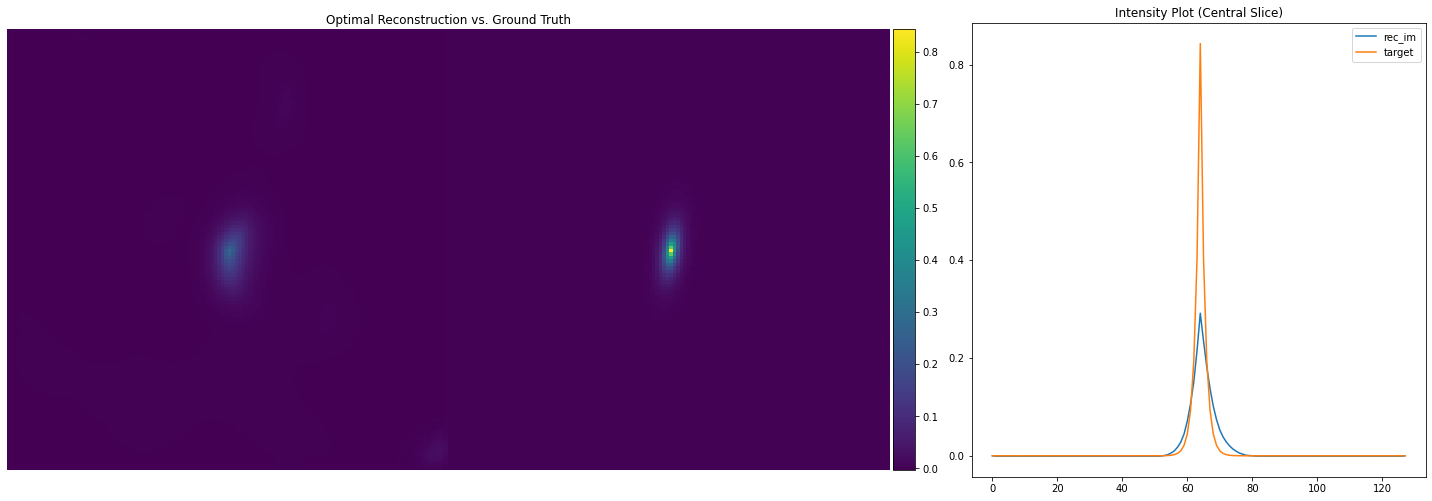

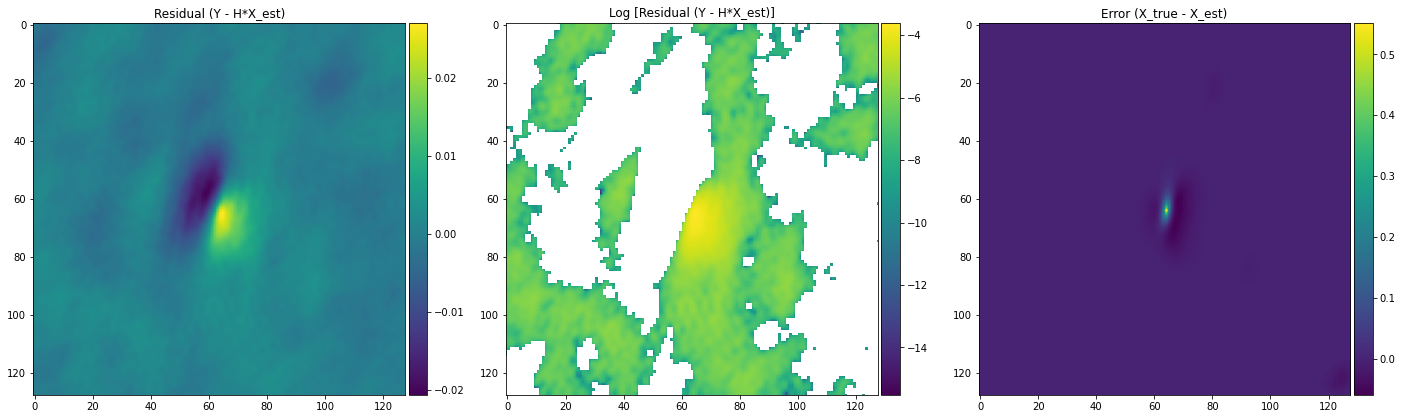

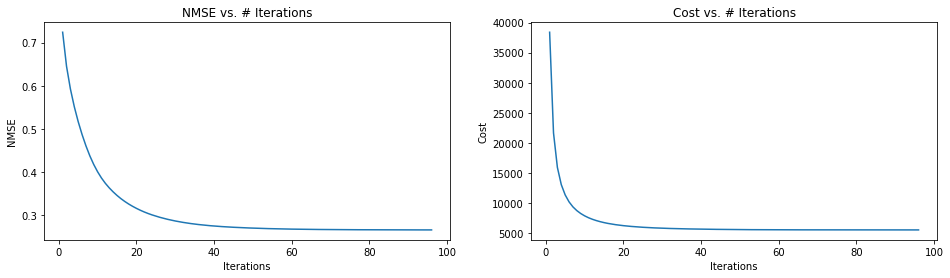


Minimum NMSE = 0.2665095627307892 (at [96] iterations)
Minimum Cost = 5580.2099609375 (at [96] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1490



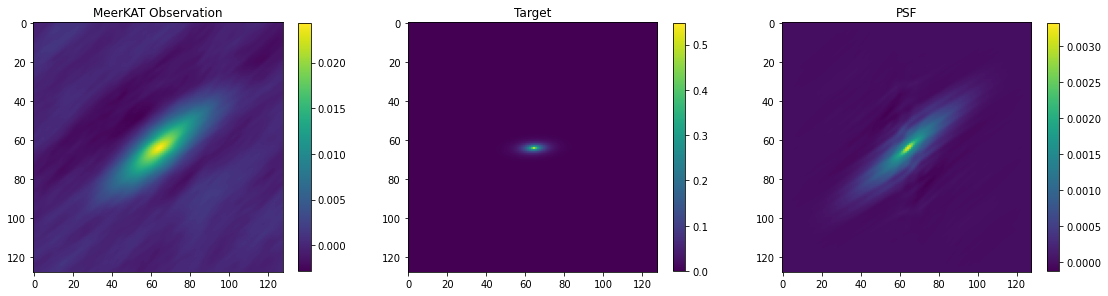

SNR (in Direct Space) = 27.20622716013849
Noise Std (in Direct Space) = 0.0008935028562555089
PSF Flux =  1.0000002



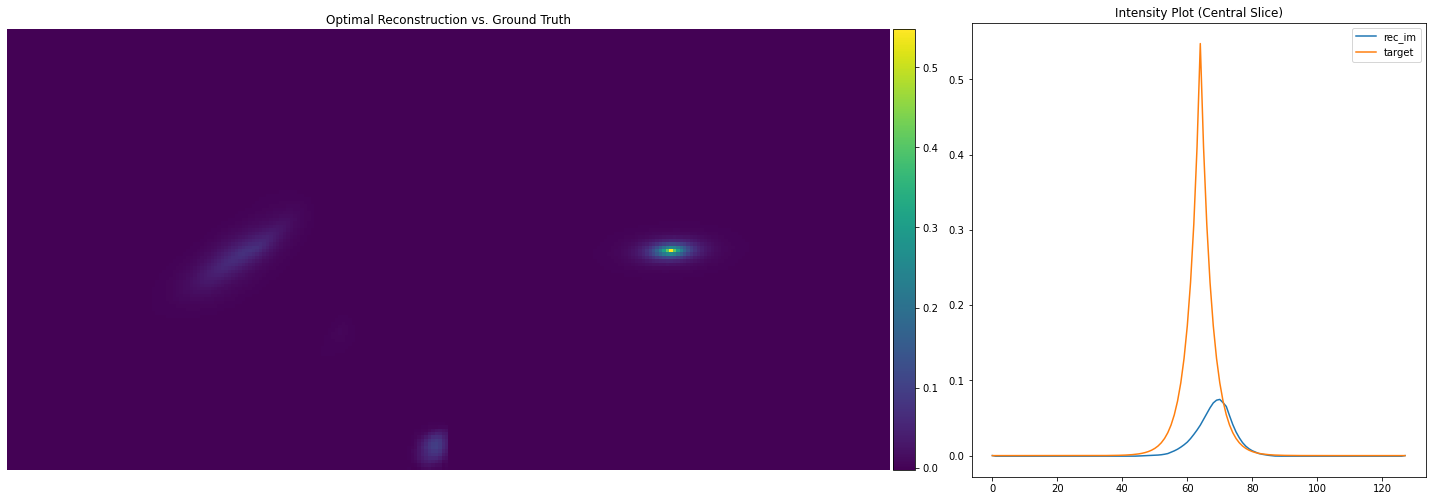

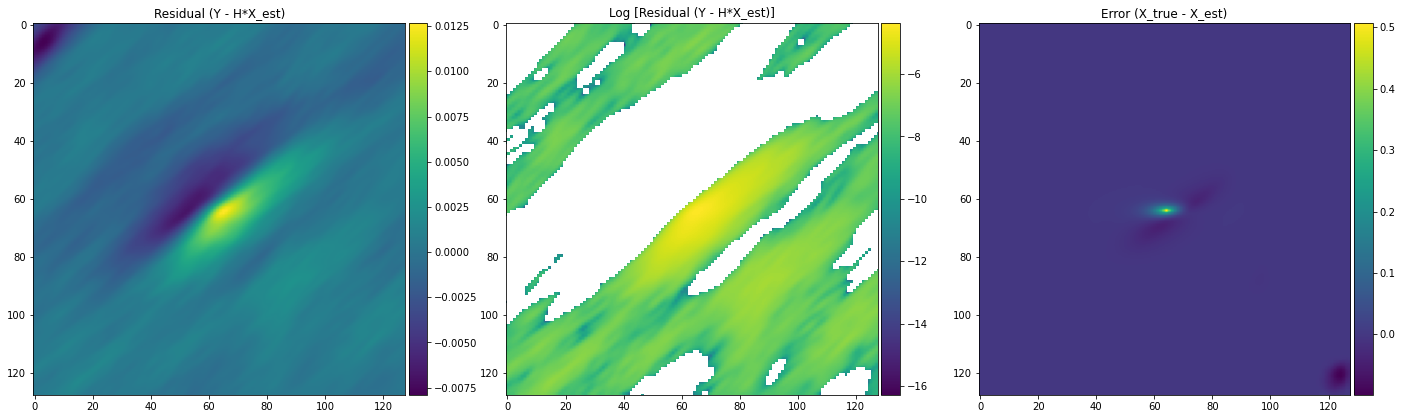

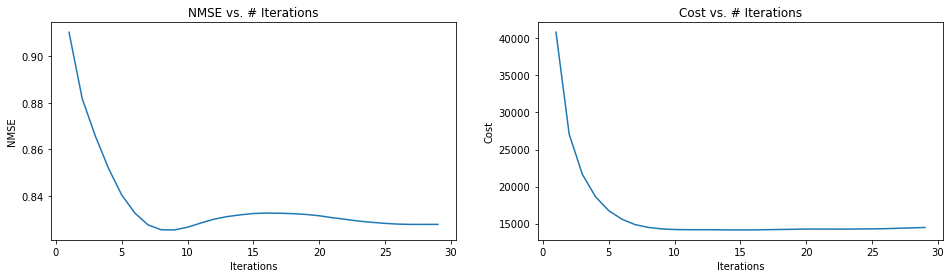


Minimum NMSE = 0.8254461288452148 (at [9] iterations)
Minimum Cost = 14154.8779296875 (at [15] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1480



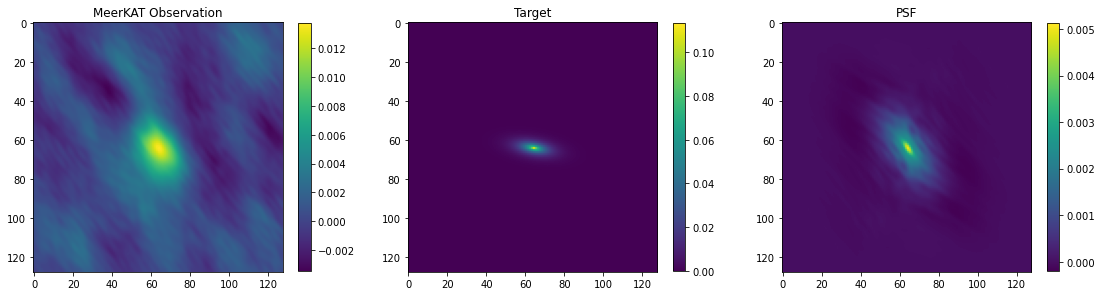

SNR (in Direct Space) = 9.155669446587432
Noise Std (in Direct Space) = 0.0014989124191459268
PSF Flux =  0.99999994



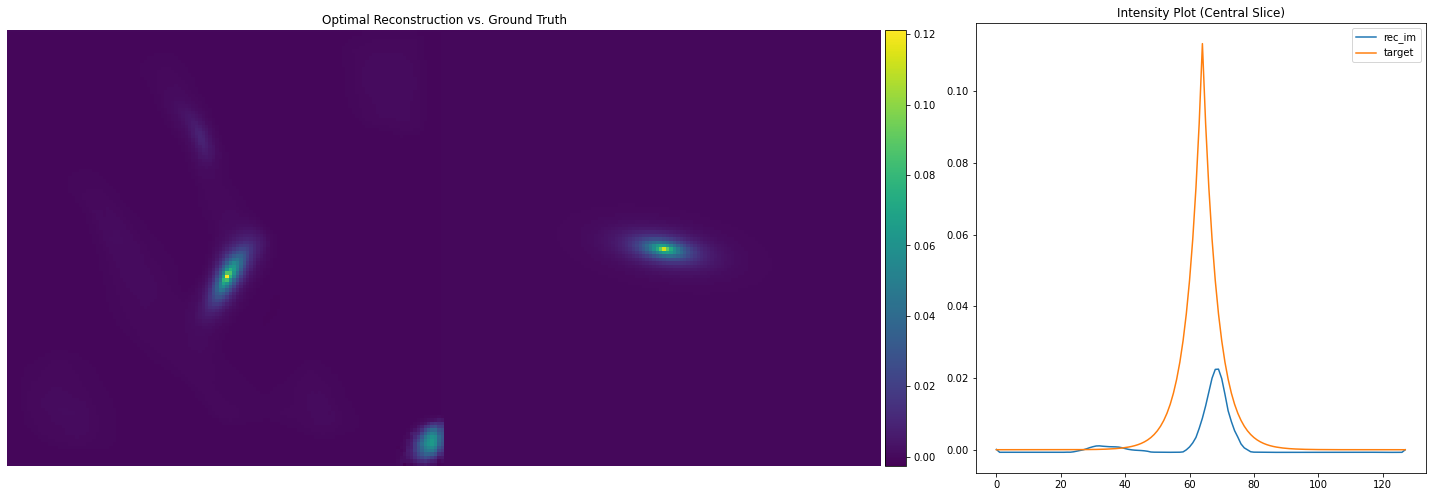

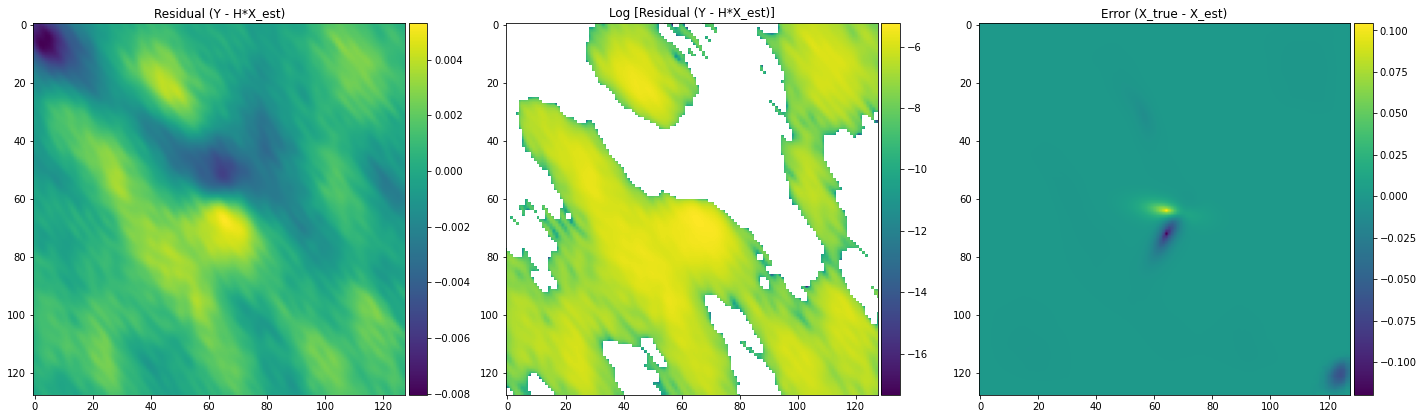

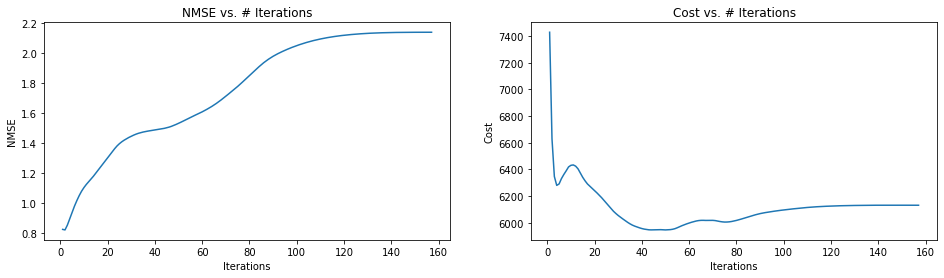


Minimum NMSE = 0.8210389018058777 (at [2] iterations)
Minimum Cost = 5946.82470703125 (at [50] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1470



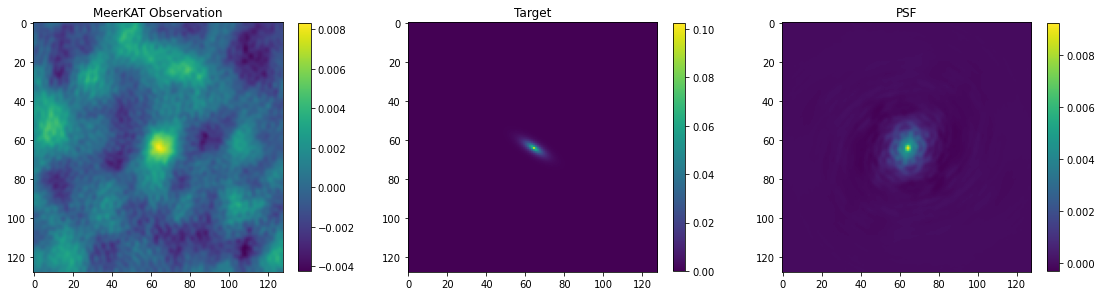

SNR (in Direct Space) = 5.51895787858728
Noise Std (in Direct Space) = 0.0015049764546565712
PSF Flux =  1.0000005



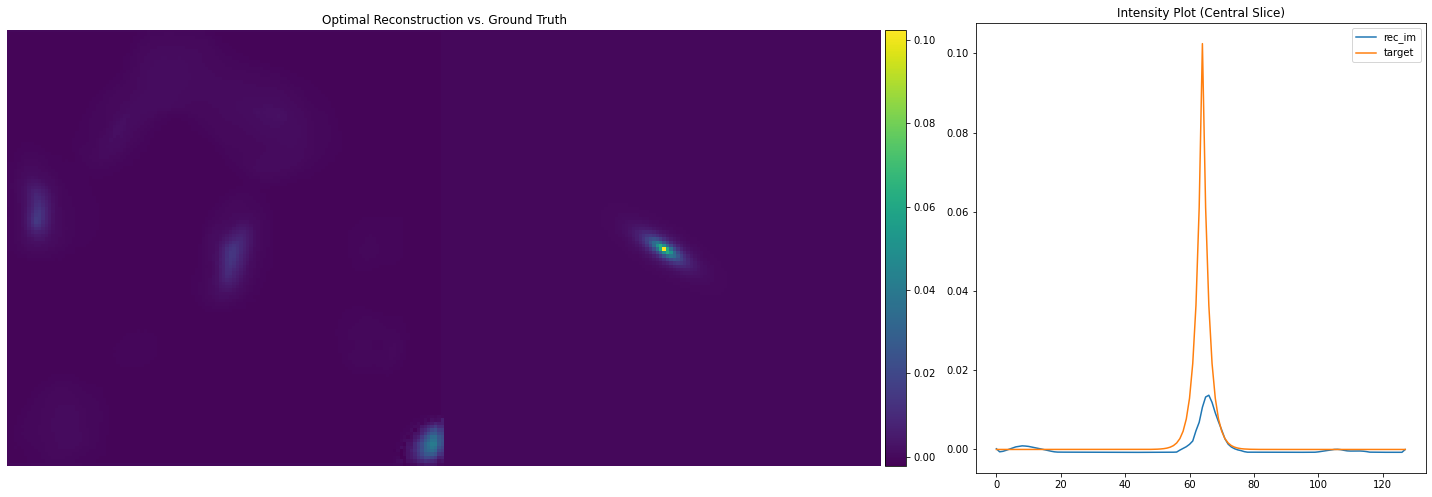

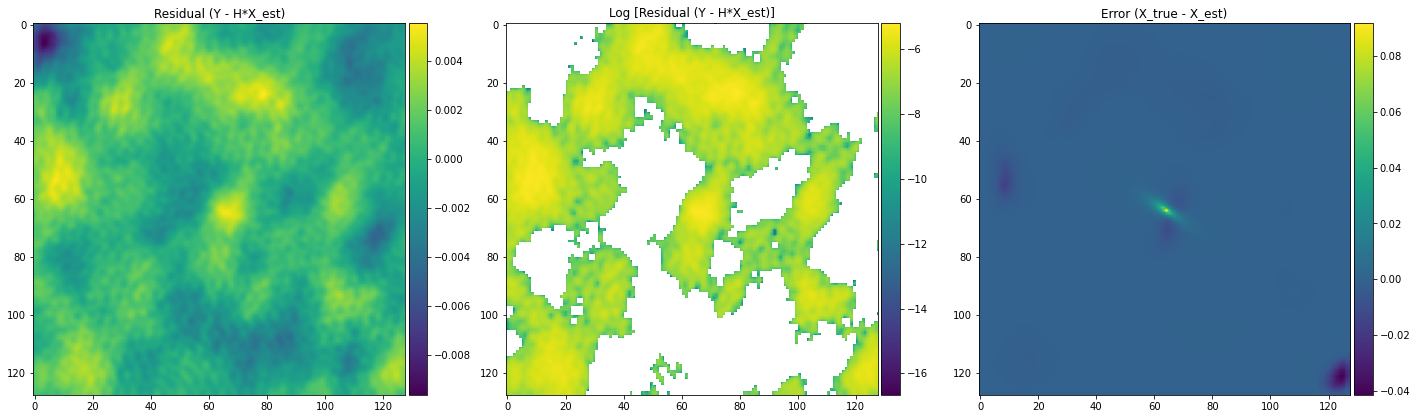

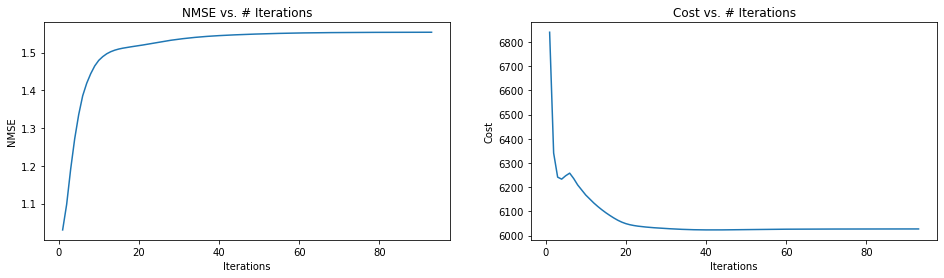


Minimum NMSE = 1.030422568321228 (at [1] iterations)
Minimum Cost = 6023.35595703125 (at [42] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1460



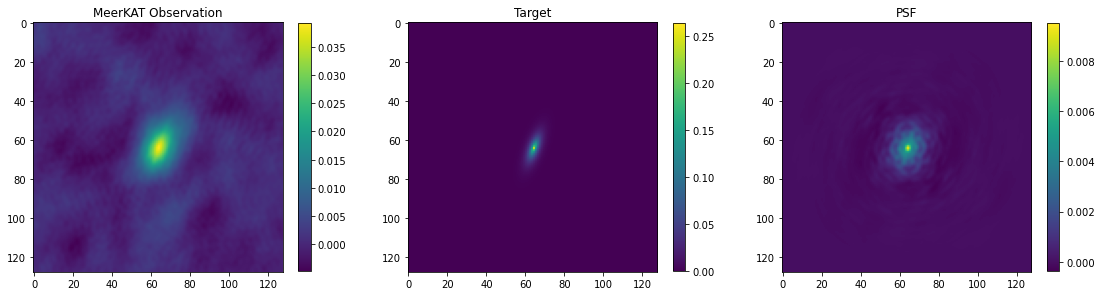

SNR (in Direct Space) = 22.18919261102072
Noise Std (in Direct Space) = 0.0017655325302388517
PSF Flux =  0.99999964



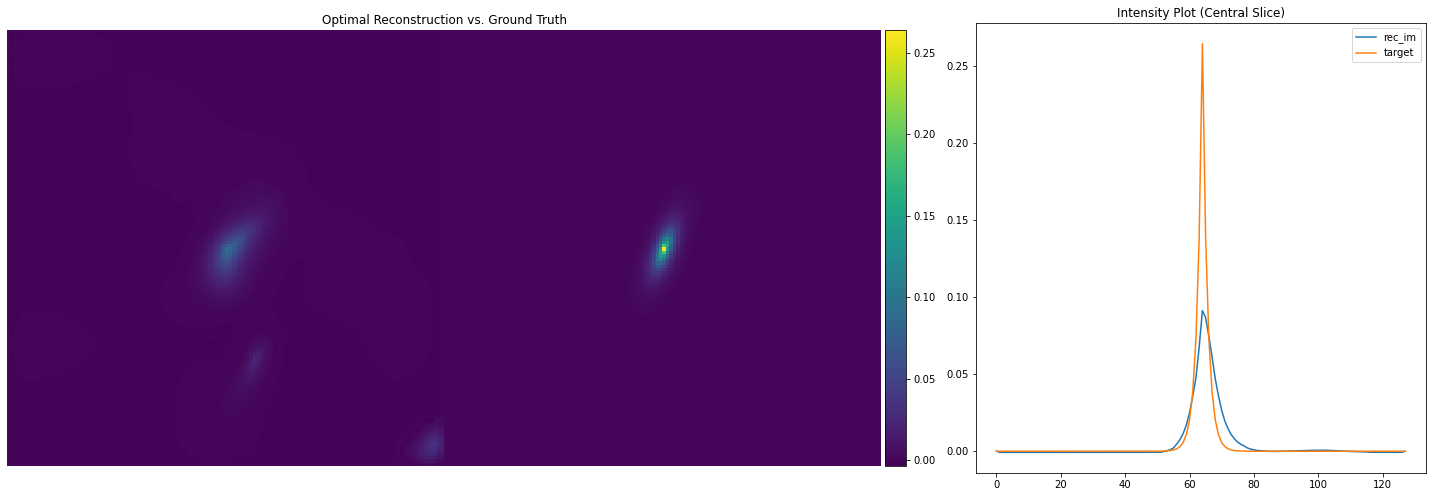

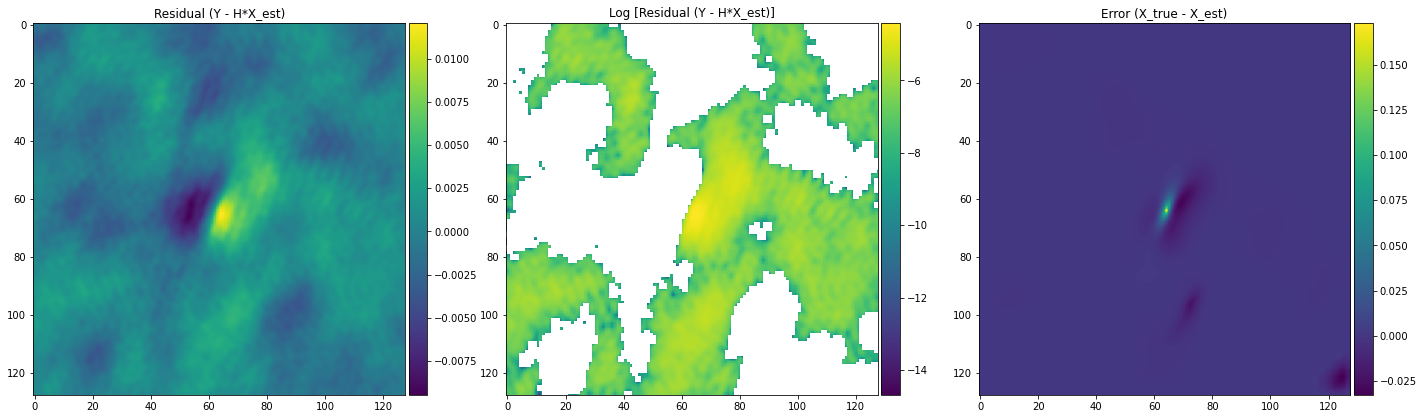

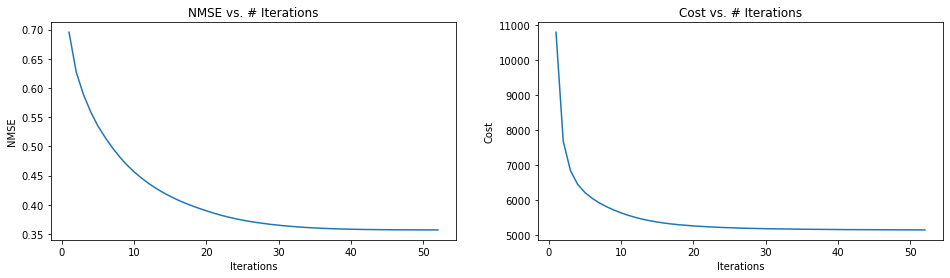


Minimum NMSE = 0.35700514912605286 (at [52] iterations)
Minimum Cost = 5146.14453125 (at [52] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1450



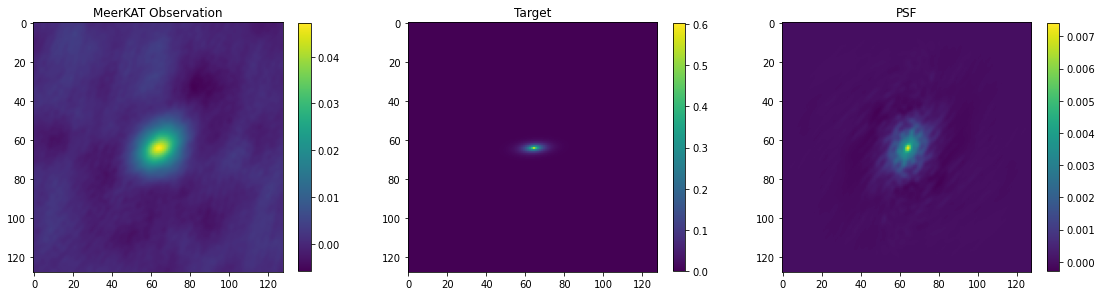

SNR (in Direct Space) = 26.991432429838127
Noise Std (in Direct Space) = 0.001747346809809096
PSF Flux =  1.0



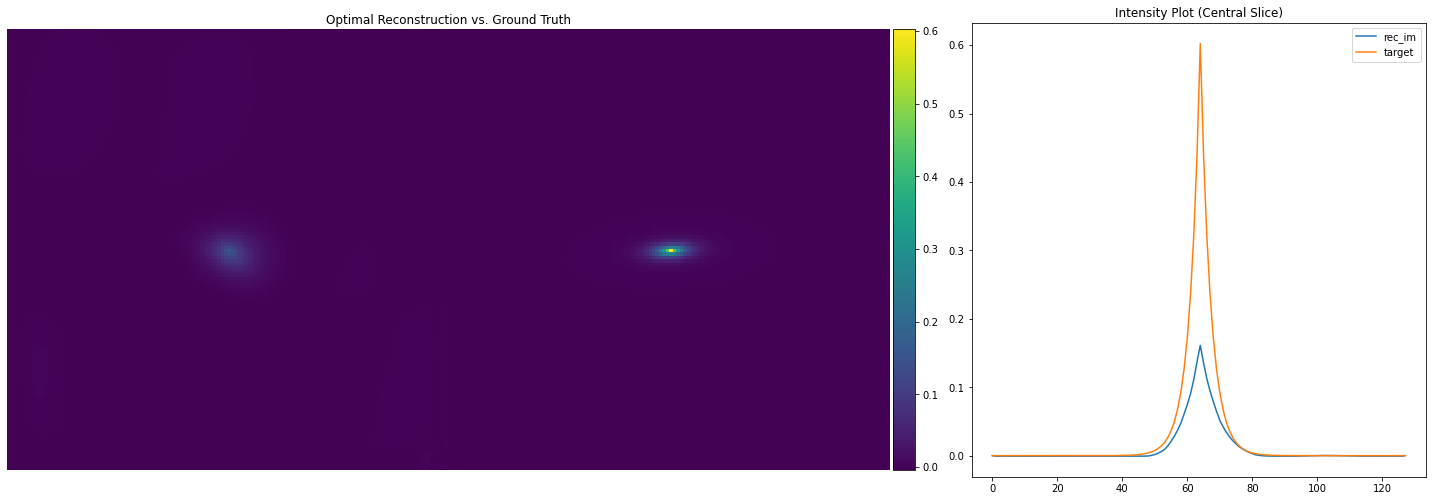

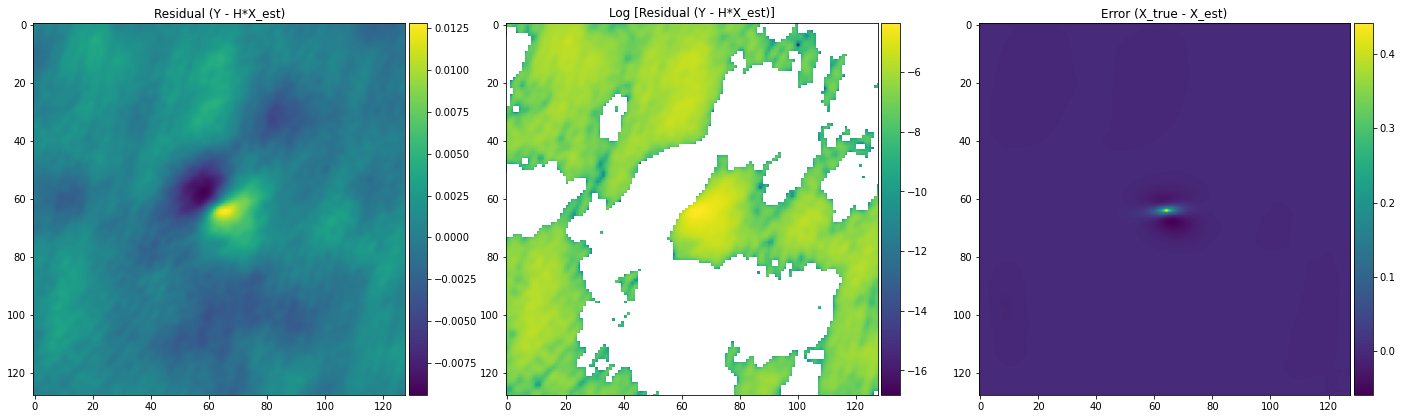

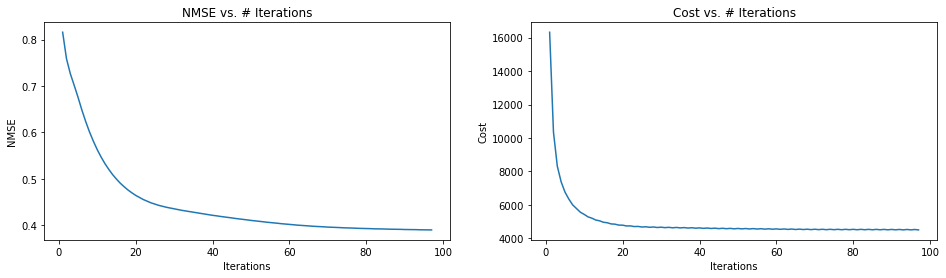


Minimum NMSE = 0.3901769816875458 (at [96] iterations)
Minimum Cost = 4497.748046875 (at [97] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1440



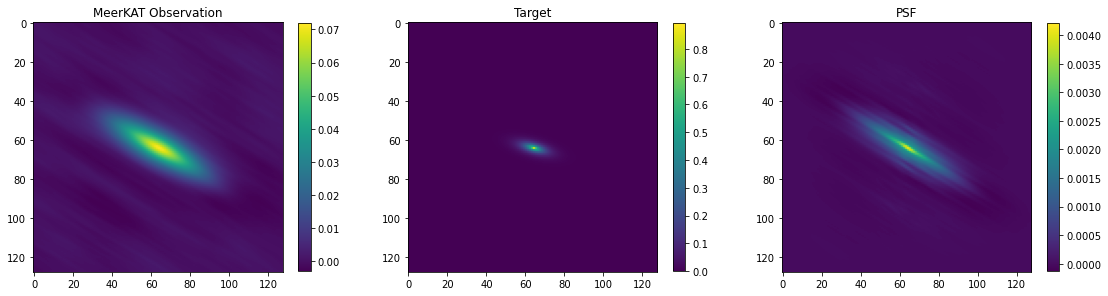

SNR (in Direct Space) = 66.1408892770529
Noise Std (in Direct Space) = 0.00108718246165663
PSF Flux =  0.99999964



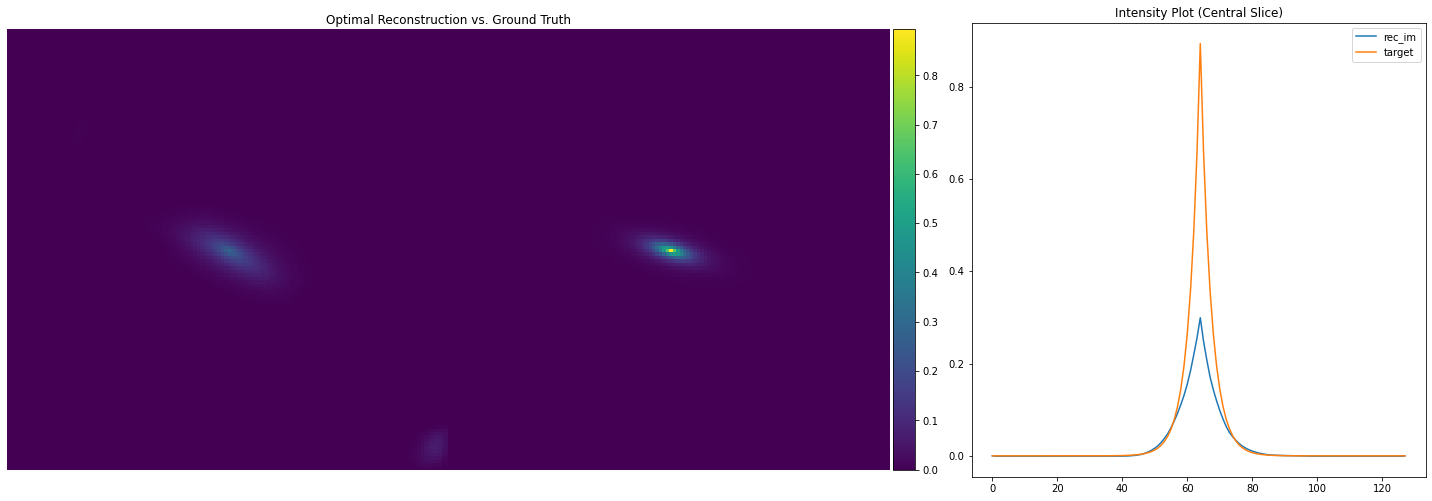

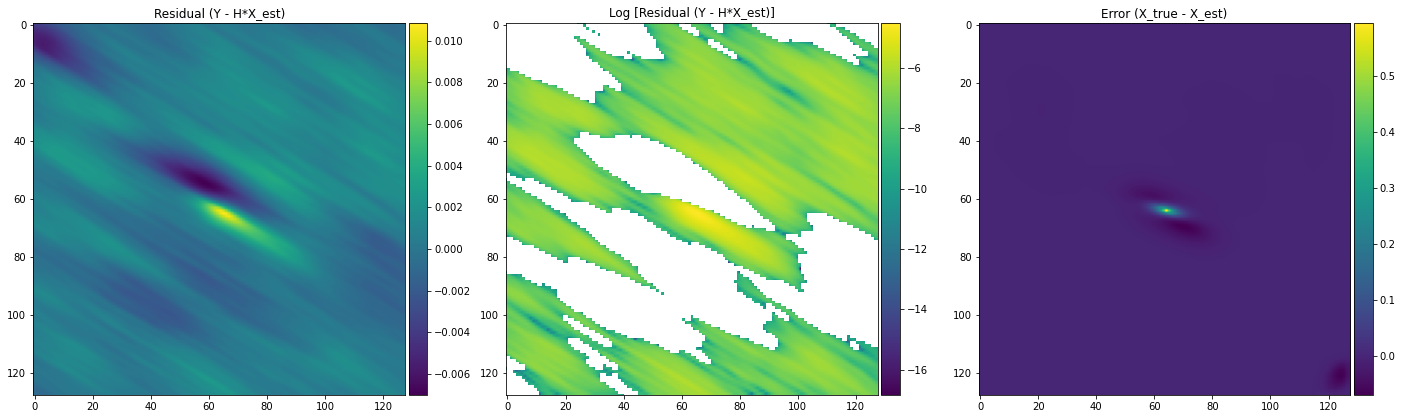

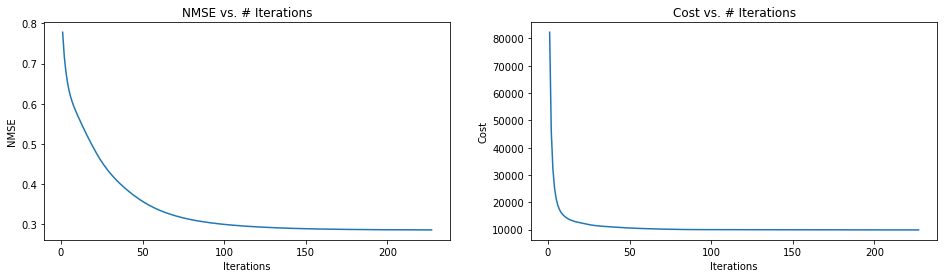


Minimum NMSE = 0.2862038314342499 (at [227] iterations)
Minimum Cost = 9894.9453125 (at [227] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1430



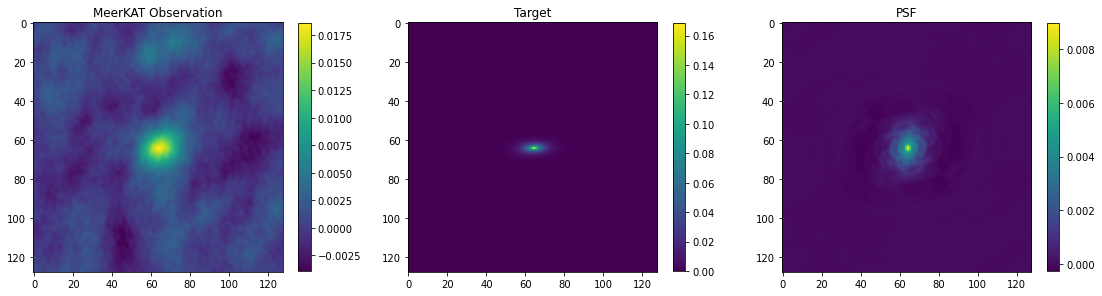

SNR (in Direct Space) = 12.90302512407445
Noise Std (in Direct Space) = 0.0014394049930851905
PSF Flux =  1.0000002



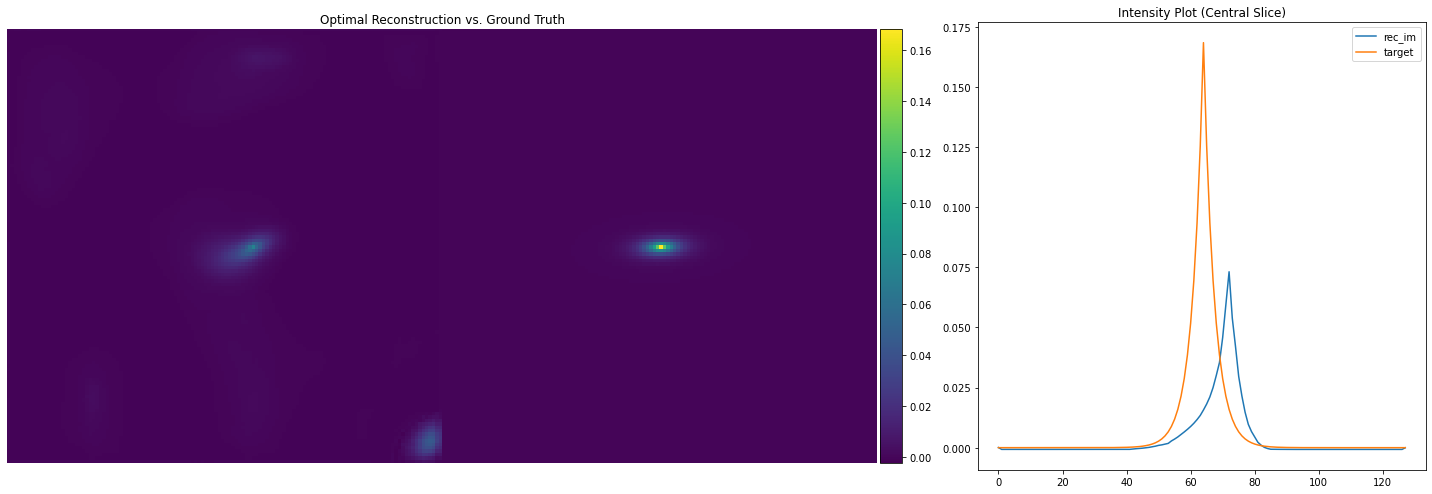

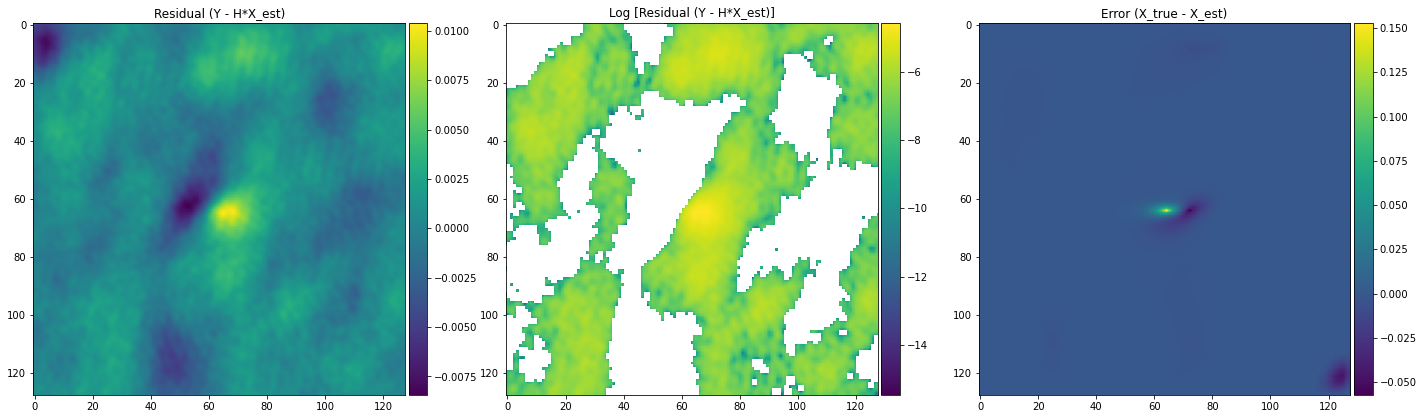

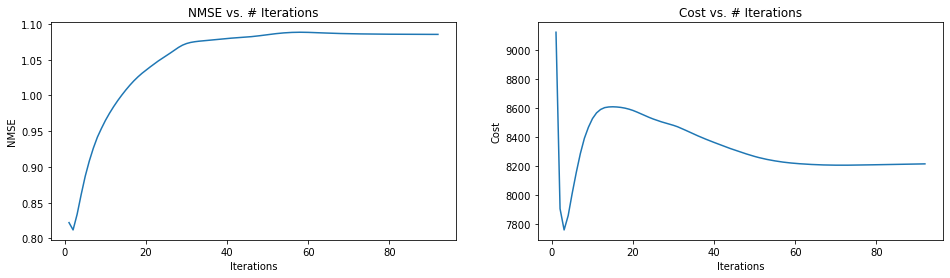


Minimum NMSE = 0.8118652105331421 (at [2] iterations)
Minimum Cost = 7760.72802734375 (at [3] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1420



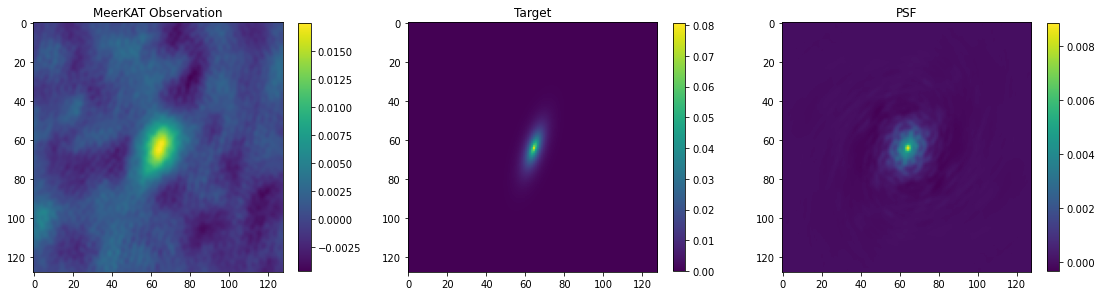

SNR (in Direct Space) = 10.606502560242326
Noise Std (in Direct Space) = 0.0016490400158800183
PSF Flux =  1.0000002



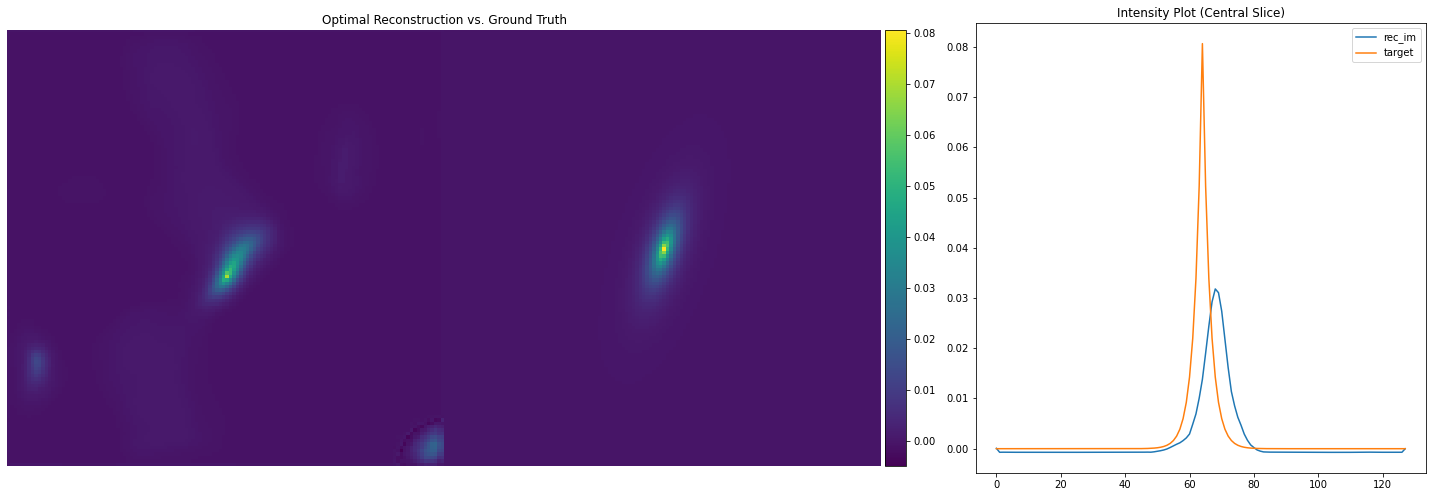

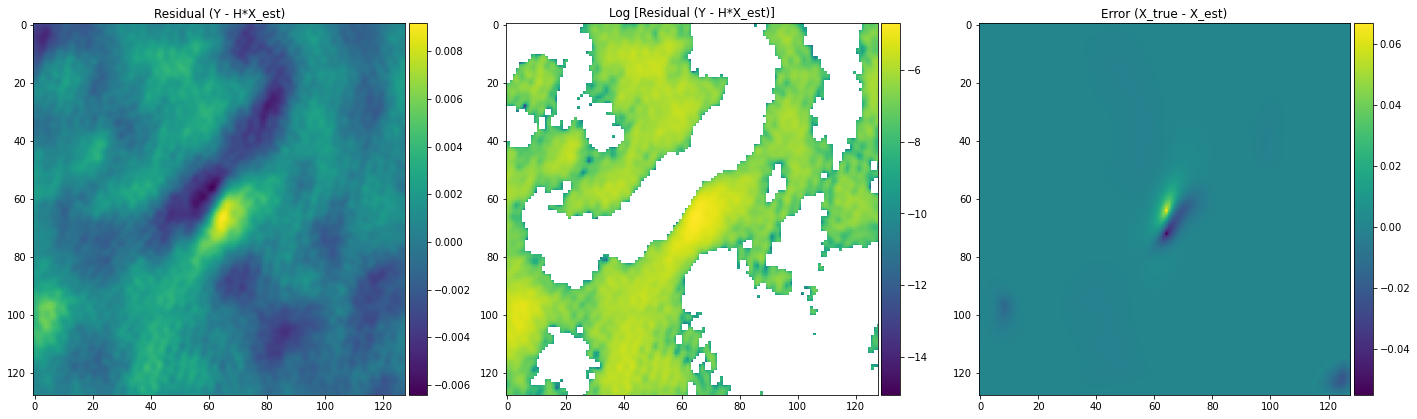

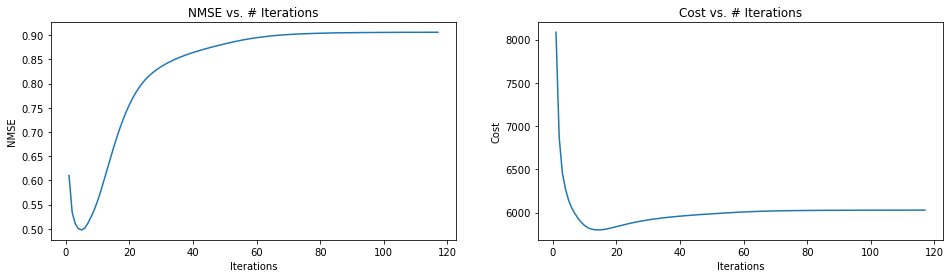


Minimum NMSE = 0.4977450966835022 (at [5] iterations)
Minimum Cost = 5800.19677734375 (at [14] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1410



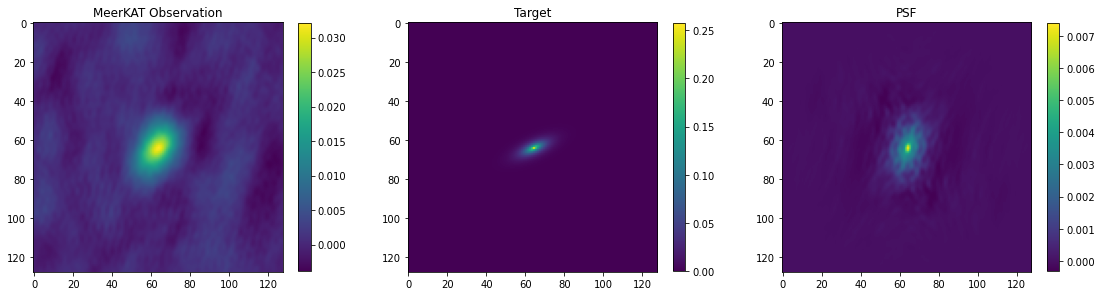

SNR (in Direct Space) = 22.111580906322608
Noise Std (in Direct Space) = 0.0014514667867217212
PSF Flux =  0.9999998



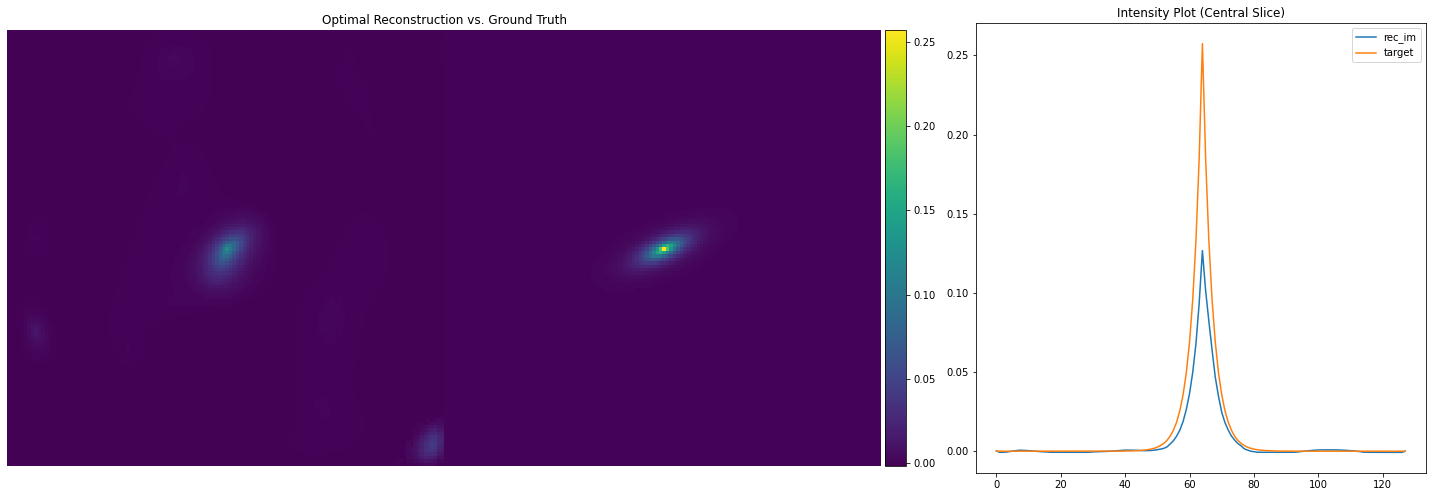

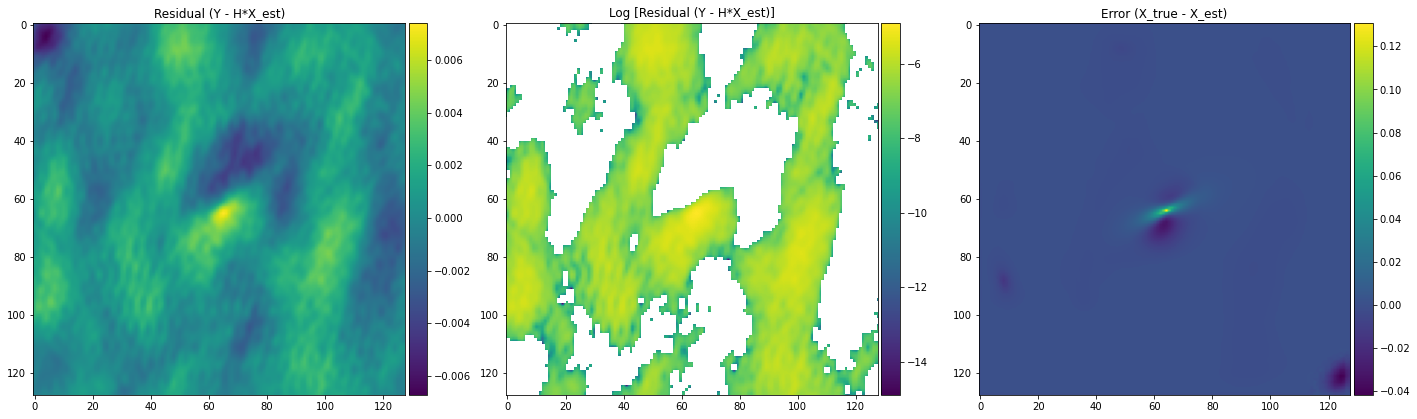

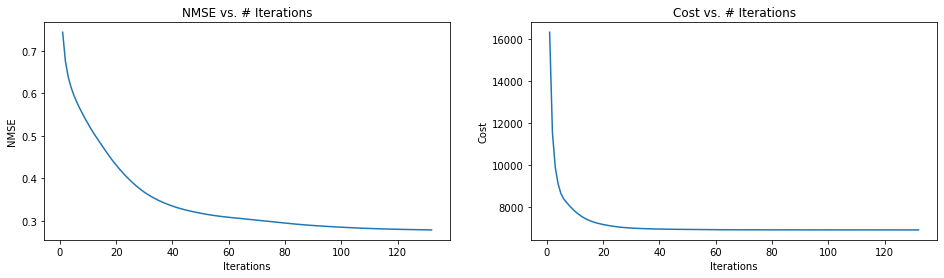


Minimum NMSE = 0.27827709913253784 (at [132] iterations)
Minimum Cost = 6908.68603515625 (at [131 132] iterations)

_______________________________________________________________________________________________________




In [10]:
n_iter = 500

x_0 = np.zeros(batch['inputs'][0].shape)

x_opt = np.zeros((200, batch['inputs'].shape[1], batch['inputs'].shape[2]))                                 
nmse_arr = np.zeros((200, n_iter))          
cost = np.zeros((200, n_iter)) 


# Deconvolve given images
for gal_ind in range(1600, 1400, -1):            
    
    gal_input = tf.cast(np.squeeze(batch['inputs'][gal_ind]), tf.float32)
    gal_target = np.squeeze(batch['targets'][gal_ind])
    psf = tf.cast(np.squeeze(batch['psf'][gal_ind]) , tf.float32)       
    sigma_noise = sigma_mad(gal_input)    
    SNR_D = np.max(gal_input) / sigma_noise         # SNR in direct space

    if gal_ind%10 == 0:
        
        print('\n\n Galaxy Index = {}'.format(gal_ind))
        
        # Plot input, target & psf 
        plot_utils.plot_gal_psf_radio(gal_input, gal_target, psf, sigma_noise, SNR_D)

    # Deconvolve the image
    x_opt[1600-gal_ind], cost[1600-gal_ind], nmse_arr[1600-gal_ind] = runFBS(gal_input, x_0, psf, grad, 
                                                                             sigma_noise, n_iter, model_1)
    if gal_ind%10 == 0:
        
        # Visual Comparison
        plot_utils.comparison(x_opt[1600-gal_ind], gal_target, gal_input, psf, fftconvolve)

        # Plot NMSE & Cost
        plot_utils.nmse_cost(nmse_arr[1600-gal_ind], cost[1600-gal_ind], n_iter)


### Save Output

In [11]:
FBS_output_meerkat = {}
FBS_output_meerkat['x_opt'] = x_opt
FBS_output_meerkat['nmse'] = nmse_arr
FBS_output_meerkat = dict(chain.from_iterable(d.items() for d in (FBS_output_meerkat, batch)))

In [12]:
# Save FBS Output
f = open(data_path + "FBS_output_meerkat.pkl", "wb")
pickle.dump(FBS_output_meerkat, f)
f.close()